In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.transforms import Bbox
plt.style.use('ggplot')

In [2]:
# ggplot style C1=#348ABD
c1 = np.array([52,138,189]) / 255

rgb = lambda x: np.array(matplotlib.colors.to_rgb(x))

## Figure S1

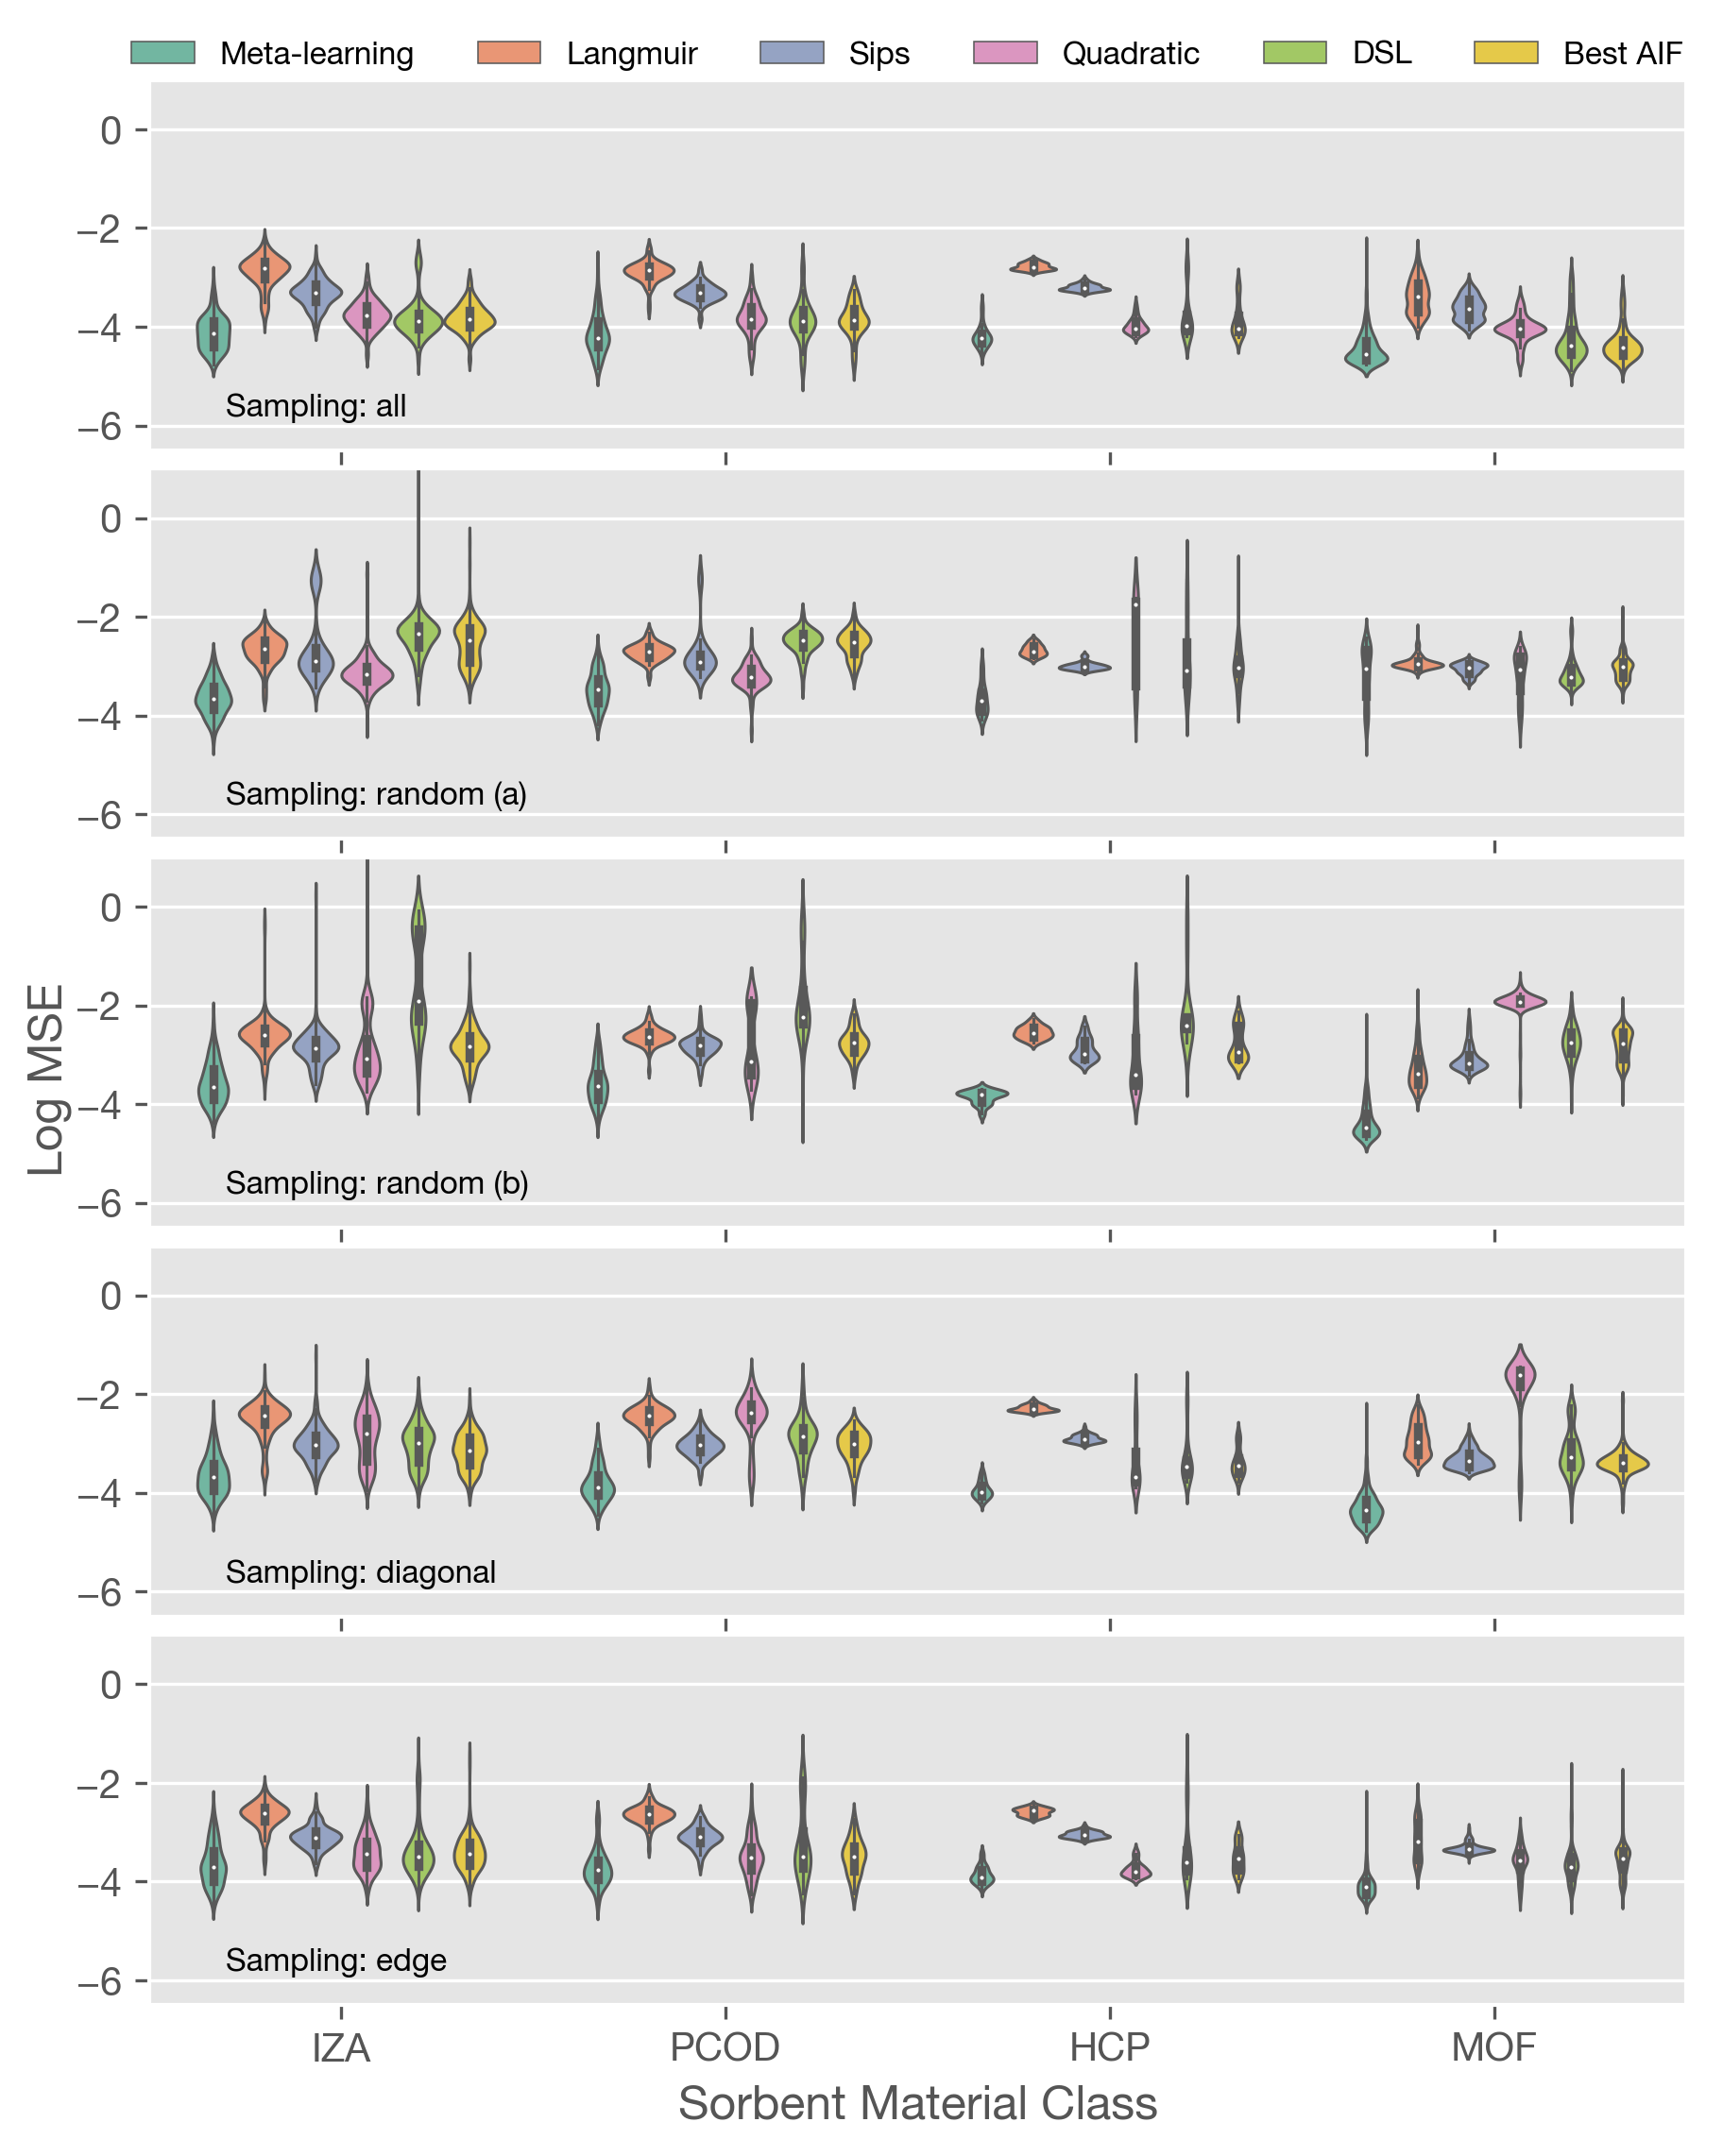

In [3]:
columns = ['Dataset', 'Sampling', 'Model', 'Log MSE']
modes = ['regular', 'random8', 'random8_1', 'diagonal', 'edge']
isotherms = ['langmuir', 'sips', 'quadratic', 'dslangmuir', 'best']
isotherm_names = ["Langmuir", "Sips", "Quadratic", "DSL", "Best AIF"]
rows = []
for mode in modes:
    for dataset in ['iza', 'pcod', 'hcp', 'mof']:
        fits_nn = np.loadtxt('results/%s/nn-%s.csv' % (dataset, mode), delimiter=',')[:, -1]
        for x in fits_nn:
            rows.append([dataset.upper(), mode, "Meta-learning", np.log10(x)])
        for i, n in enumerate(isotherms):
            fits_isotherm = np.loadtxt(
                'results/%s/%s-fit-%s.csv' % (dataset, n, mode), delimiter=',')
            if len(fits_isotherm.shape) == 2:
                fits_isotherm = fits_isotherm[:, -1]
            for x in fits_isotherm:
                rows.append([dataset.upper(), mode, isotherm_names[i], np.log10(x)])
df = pd.DataFrame(rows, columns=columns)
titles = ["all", "random (a)", "random (b)", "diagonal", "edge"]

fig, axes = plt.subplots(5, 1, dpi=300)
axes = axes.ravel()
fig.set_size_inches(7, 9)
plt.subplots_adjust(hspace=0.05)
for ax, mode, title in zip(axes, modes, titles):
    ax.text(-0.3, -5.8, "Sampling: " + title, fontsize=8, fontweight='regular')
    plot = sns.violinplot(ax=ax, data=df.loc[df['Sampling'] == mode], 
                   x="Dataset", y="Log MSE", hue="Model", 
                   split=False, palette="Set2", linewidth=0.75,
                   )
    ax.set_ylim([-6.5, 1])

    
plot.legend(loc='lower left', bbox_to_anchor=(-0.03, 5.15), ncol=6, fontsize=8,frameon=False)
for i in range(4):
    axes[i].get_legend().remove()
    axes[i].set_ylabel("")
    axes[i].set_xlabel("")
    axes[i].set_xticklabels([])
axes[-1].set_xlabel("Sorbent Material Class")
axes[-1].yaxis.set_label_coords(-0.05, 2.5)
#plt.savefig('figure-S1.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Figure S2

**Note**: The "best isotherm" selection is manually performed again using the full 64-state-point data. This is because the reported best AIF used a different coefficent range when performing the least square fit due to stability in few-shot fitting. Conversely, applying the 64-state-point selection to the few-shot case will result in data leak.

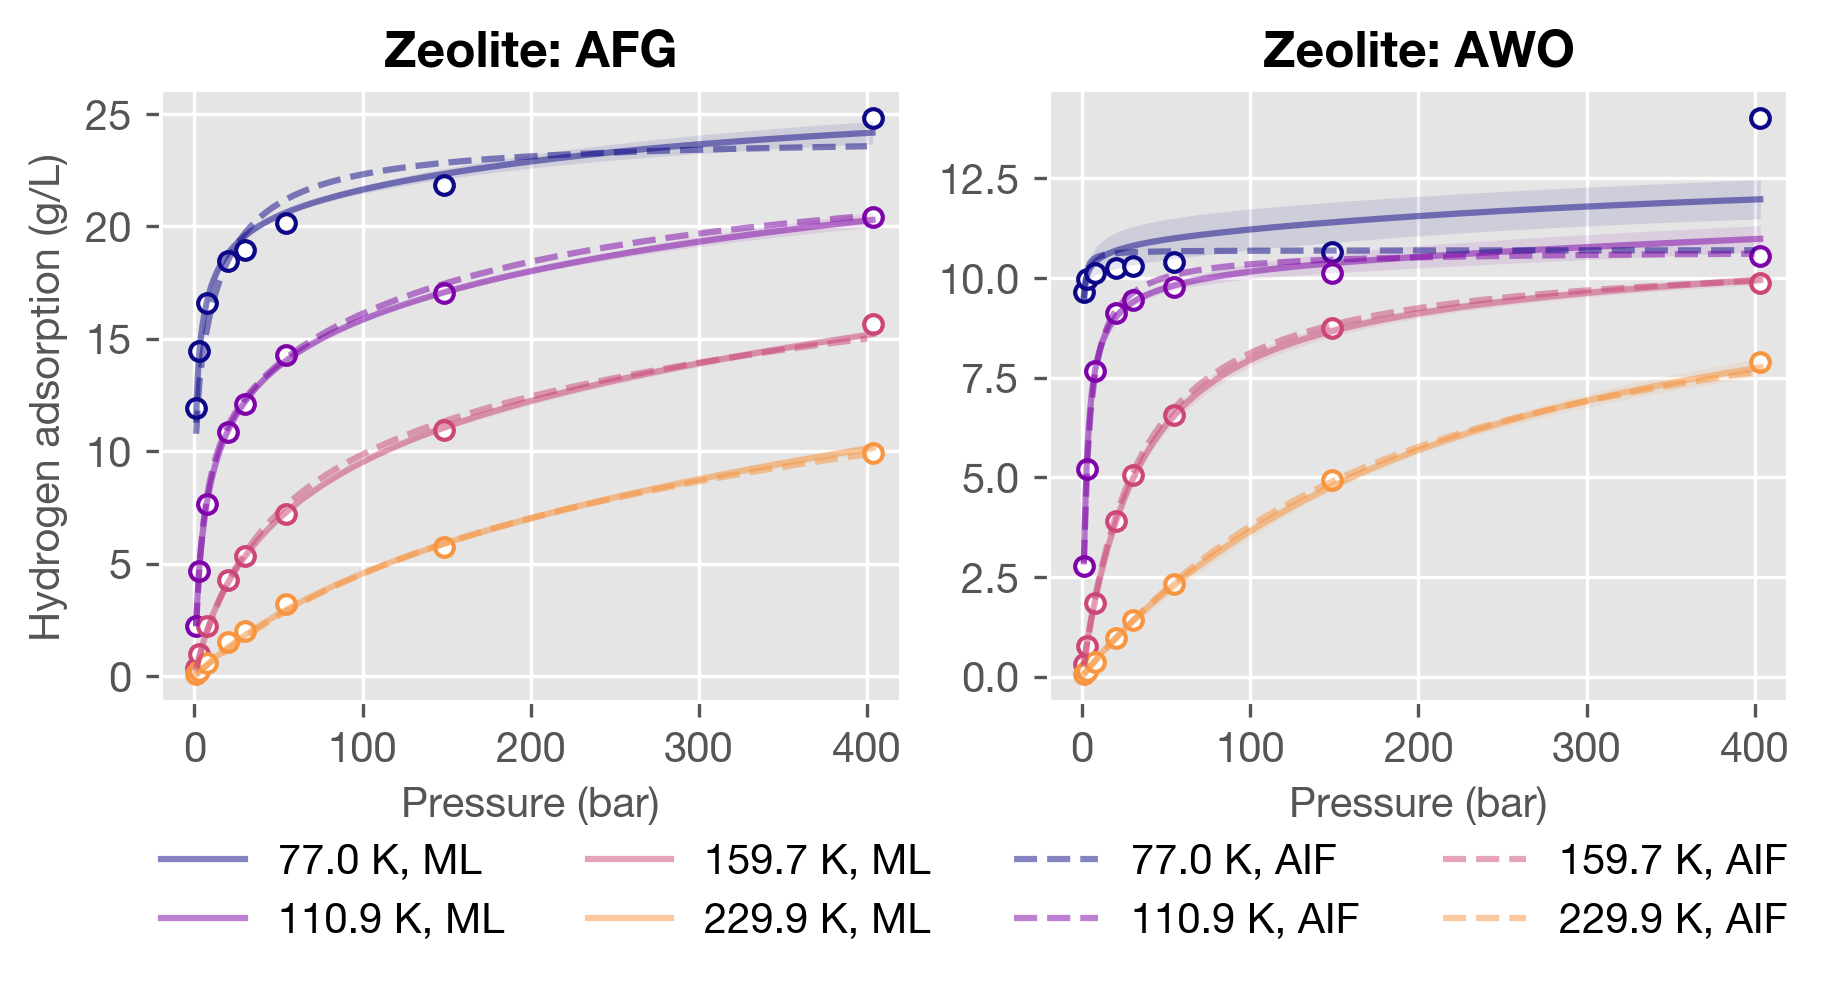

In [4]:
import os, sys
sys.path.append(os.getcwd() + '/../sorbmetaml/')
from fit_isotherm import Isotherm

ml_fit_err = np.loadtxt("results/iza/nn-regular.csv", delimiter=",")[:, -1]
error = []
coefficients = {}
for aif in ["langmuir", "sips", "dslangmuir", "quadratic"]:
    aif_fit = np.loadtxt("results/iza/%s-fit-regular.csv" % aif, delimiter=",")
    error.append(aif_fit[:, -1])
    coefficients[aif] = aif_fit[:, :-1]
error = np.array(error)

best_aif_err = np.min(error, axis=0)
best_aif_type = np.argmin(error, axis=0)
diff = best_aif_err - ml_fit_err
indices = np.argsort(diff)

data = pd.read_csv('../data/iza/iza_hydrogen.csv', index_col=0)
temperatures = [77.0, 110.88, 159.67, 229.92]
pressures = np.array([1.0, 2.71, 7.39, 20.09, 30.0, 54.60, 148.4, 403.4])

cmap = matplotlib.cm.get_cmap('plasma', 9)
colors = cmap(range(12))[::2]

zeolite_names = [x.split("-")[0] for x in np.genfromtxt("../data/iza/names.csv", dtype=str)]
norms = np.loadtxt("../data/iza/norms.csv")
zeolites_plot = np.array(zeolite_names)[indices[-2:]]

def plot_simulation(axes):
    for j, key in enumerate(zeolites_plot):
        ax = axes[j]
        ax.set_title("Zeolite: %s" % key, fontsize=12, fontweight="bold")
        for i, zipped in enumerate(zip(colors[:4], temperatures)):
            c, temp = zipped
            loadings = data.loc[np.logical_and(
                    data['zeolite'] == key + '-0', 
                    data['temperature'] == temp)].sort_values('pressure')['loading (v)'].values
            ax.scatter(pressures, loadings * 2.0158, 
                    color='1', linewidth=1, edgecolors=c, s=20)
    for ax in axes:
        ax.set_xlabel('Pressure (bar)',fontsize=10)
        ax.set_xlim([-20, 420])
        ax.set_xticks([0, 100, 200, 300, 400])

def plot_isotherms(axes, gen_pred, **kwargs):
    lines = []
    for j, key in enumerate(zeolites_plot):
        ax = axes[j]
        data_pred = gen_pred(key)
        for i, zipped in enumerate(zip(colors[:4], temperatures)):
            c, temp = zipped
            x, y_pred, y_err = data_pred(i)
            line = ax.plot(x, y_pred, color=c, **kwargs)[0]
            if j == 0:
                lines.append(line)
            if y_err is not None:
                ax.fill_between(x, y_pred - y_err, y_pred + y_err, color=c, alpha=0.1, lw=0)    
    return lines

def get_ml_pred(key):
    data_pred = np.loadtxt('results/isotherms/%s-0.txt' % key)
    def _wrapper(itemp):
        x = data_pred[:, 0]
        y_pred = data_pred[:, 1 + 2*itemp] * 2.0158
        y_err = data_pred[:, 2 + 2*itemp] * 2.0158
        return x, y_pred, y_err
    return _wrapper

def isotherm_predictor(name):
    isotherm = Isotherm(name).get()
    pressures = np.linspace(1, 400, 200)
    def get_ml_pred(key):
        zid = zeolite_names.index(key)
        popt = coefficients[name][zid]
        def _wrapper(itemp):
            x_fit = np.zeros((2, len(pressures)))
            x_fit[0, :] = np.log(pressures)
            x_fit[1, :] = 1000 / temperatures[itemp]
            y_pred = isotherm(x_fit, *popt) * norms[zid] * 2.0158
            return pressures, y_pred, None
        return _wrapper
    return get_ml_pred

fig, axes = plt.subplots(1, len(zeolites_plot))
fig.set_size_inches(3.5 * len(zeolites_plot), 3)
fig.set_dpi(300)
plt.subplots_adjust(wspace=0.2, bottom=0.2)
axes[0].set_ylabel('Hydrogen adsorption (g/L)',fontsize=10)
plot_simulation(axes)
lines = []
lines += plot_isotherms(axes, get_ml_pred, ls='-', alpha=0.5)
lines += plot_isotherms(axes, isotherm_predictor("quadratic"), ls='--', alpha=0.5)
axes[0].legend(lines, ["%.1f K, ML" %x for x in temperatures] + 
              ["%.1f K, AIF" %x for x in temperatures], 
           loc='lower left', bbox_to_anchor=(-0.05, -0.45), ncol=4, frameon=False)
#plt.savefig("figure-S2.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Figure S3
Figure S3 is produced using VMD. The trajectory data for Figure S3 is located at `config/AWO-P148-T77.xyz` and `config/AWO-P403-T77.xyz`.

## Figure S4
**Evaluating this cell requires PyTorch to calculate the gradients from the ML model.**

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


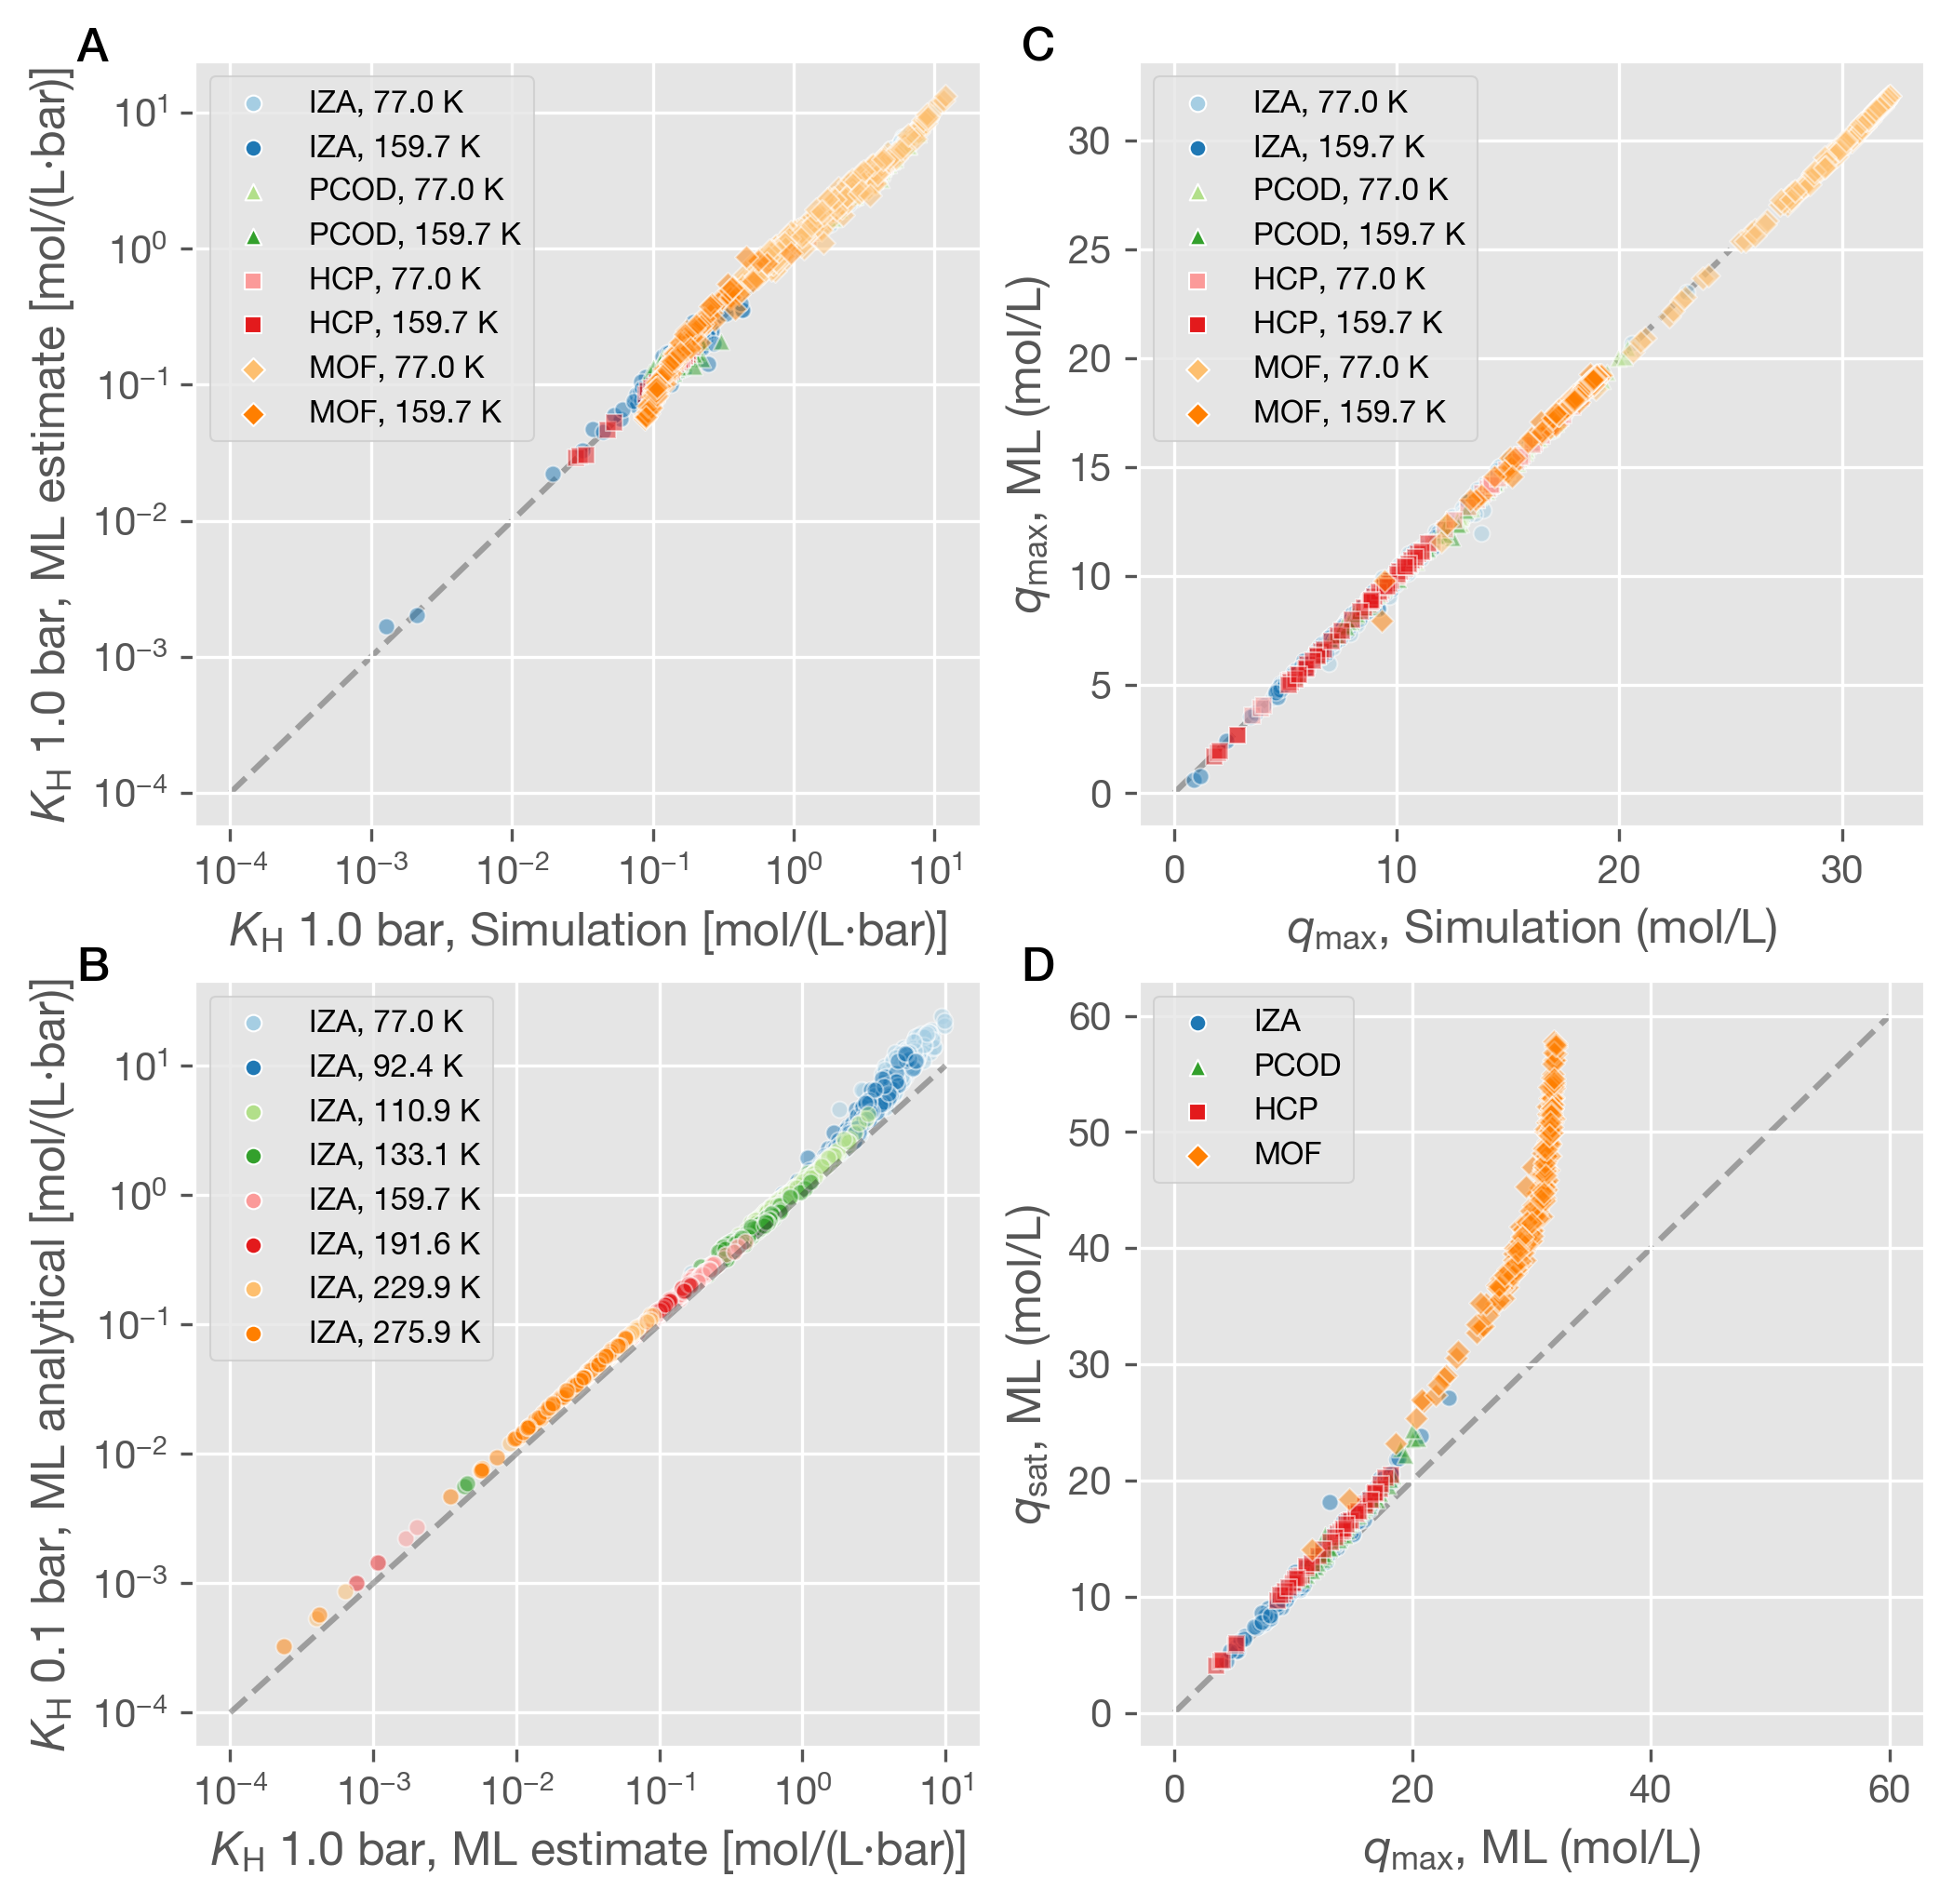

In [5]:
import os, sys
import torch
sys.path.append(os.getcwd() + '/../sorbmetaml/')

from models import MLModel, wrapper
from utils import fetch_models

materials = ["iza", "pcod", "hcp", "mof"]
model = {}
names = {}
norms = {}
data_true = {}
data_pred = {}

for material in materials:
    model_path = "../models/model.pt" if material != "mof" else "../models/model-mof.pt"
    data = torch.from_numpy(np.load("../data/%s/%s_hydrogen.npy" % (material, material)).astype(np.float32))
    if material in ["hcp", "mof"]:
        data = data.view(data.shape[0], data.shape[1], 8, 8)
        pressure_order = torch.argsort(data[0, 1, 0, :])
        data = data[:, :, :, pressure_order]
        data = data.permute(0, 1, 3, 2).contiguous()
        data = data.view(data.shape[0], data.shape[1], 64)
    with torch.no_grad():
        net = MLModel(5)
        net.load_state_dict(torch.load(model_path, map_location="cuda:0"))
        model[material] = net
        latents, _ = net.encoder(data)
        y_pred = net.decoder(latents, data[:, 1:, :]).view(data.shape[0], -1)
    norms[material] = np.loadtxt("../data/%s/norms.csv" % material)
    names[material] = np.genfromtxt("../data/%s/names.csv" % material, dtype=str)
    data_true[material] = data
    data_pred[material] = y_pred.numpy()
    
def decoder_gradient(decoder, z, x, output_y=False):
    z = torch.tensor(z)
    x = torch.tensor(x)
    x.requires_grad = True
    y_pred = decoder(z, x)
    torch.sum(y_pred).backward()
    if output_y:
        return x.grad.cpu().numpy(), y_pred.detach().cpu().numpy().reshape(z.shape[0], -1)
    else:
        return x.grad.cpu().numpy()

from matplotlib.ticker import MultipleLocator, AutoMinorLocator, NullLocator

'''
These two functions use linear index to query
temperature/pressure. This requies a consistent temperature
pressure order in DATA array.
'''
def henry_coef(data, norm):
    # indices 0..7 are the lowest pressure
    # pressure is 1 bar, return units are mol/(L bar)
    return data[:, :8] * norm.reshape(-1, 1)

def max_loading(data, norm):
    return data[:, -8:] * norm.reshape(-1, 1)

################################
def henry_coef_tangent(net, data, norm, p, t):
    latents, _ = net.encoder(data)
    x = np.tile(np.array([np.log(p), 1000/t]).reshape(2, -1), [latents.shape[0], 1, 1]).astype(np.float32)
    grad, y_pred = decoder_gradient(net.decoder, latents, x, output_y=True)
    k_H = grad[:, 0, :] / p * norm.reshape(-1, 1)
    return k_H.ravel()

def get_loading(net, data, norm, p, t):
    latents, _ = net.encoder(data)
    x = np.tile(np.array([np.log(p), 1000/t]).reshape(2, -1), [latents.shape[0], 1, 1]).astype(np.float32)
    y_pred = net.decoder(latents, torch.tensor(x)).detach().cpu().numpy().reshape(latents.shape[0], -1)
    return y_pred * norm.reshape(-1, 1)

def saturation_factor(net, data):
    latents, _ = net.encoder(data)
    return latents[:, 0].detach().numpy()



temperatures = 1000 / np.unique(data_true['iza'][0, 2])[::-1]

cmap = matplotlib.cm.get_cmap('Paired', 12)
colors = cmap(range(8))
markers = ['o', 'o', '^', '^', 's', 's', 'D', 'D']

temp_to_plot = [0, 4]

fig, axes = plt.subplots(2, 2, figsize=(8, 8), dpi=300)
lines = []

i = 0
for m in materials:
    henry_sim = henry_coef(data_true[m][:, 0], norms[m])
    henry_pred = henry_coef(data_pred[m], norms[m])
    for j in temp_to_plot:
        lines.append(axes[0, 0].scatter(henry_sim[:, j], henry_pred[:, j], s=18, edgecolor="1", 
                   color=colors[i], marker=markers[i]))
        i += 1
axes[0, 0].set_yscale("log")
axes[0, 0].set_xscale("log")
axes[0, 0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1, 10])
axes[0, 0].yaxis.set_minor_locator(NullLocator())
axes[0, 0].set_xlabel("$K_\mathrm{H}$ 1.0 bar, Simulation [mol/(L·bar)]")
axes[0, 0].set_ylabel("$K_\mathrm{H}$ 1.0 bar, ML estimate [mol/(L·bar)]")
axes[0, 0].legend(["%s, %.1f K" % (m.upper(), x) for m in materials for x in temperatures[temp_to_plot]],
                 fontsize=8)

i = 0
for m in materials:
    max_loading_sim = max_loading(data_true[m][:, 0], norms[m])
    max_loading_pred = max_loading(data_pred[m], norms[m])
    for j in temp_to_plot:
        lines.append(axes[0, 1].scatter(max_loading_sim[:, j], max_loading_pred[:, j], s=18, edgecolor="1", 
                   color=colors[i], marker=markers[i]))
        i += 1
        
axes[0, 1].legend(["%s, %.1f K" % (m.upper(), x) for m in materials for x in temperatures[temp_to_plot]],
                 fontsize=8)
axes[0, 1].set_xlabel("$q_\mathrm{max}$, Simulation (mol/L)")
axes[0, 1].set_ylabel("$q_\mathrm{max}$, ML (mol/L)")

henry_pred = henry_coef(data_pred['iza'], norms['iza'])
for i in range(len(temperatures)):
    henry_analytical = henry_coef_tangent(model['iza'], data_true['iza'], norms['iza'], 0.1, temperatures[i])
    lines.append(axes[1, 0].scatter(henry_pred[:, i], henry_analytical, s=18, edgecolor="1", color=colors[i]))
    
axes[1, 0].set_yscale("log")
axes[1, 0].set_xscale("log")
axes[1, 0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1, 10])
axes[1, 0].yaxis.set_minor_locator(NullLocator())
axes[1, 0].set_xlabel("$K_\mathrm{H}$ 1.0 bar, ML estimate [mol/(L·bar)]")
axes[1, 0].set_ylabel("$K_\mathrm{H}$ 0.1 bar, ML analytical [mol/(L·bar)]")
axes[1, 0].legend(["IZA, %.1f K" % x for x in temperatures], fontsize=8)


for i, m in enumerate(materials):
    max_loading_pred = max_loading(data_pred[m], norms[m])
    sat_loading = norms[m] * saturation_factor(model[m], data_true[m])
    lines.append(axes[1, 1].scatter(max_loading_pred[:, 0], sat_loading, s=18, edgecolor="1", 
                       color=colors[2 * i + 1], marker=markers[2 * i]))
axes[1, 1].set_xlabel("$q_\mathrm{max}$, ML (mol/L)")
axes[1, 1].set_ylabel("$q_\mathrm{sat}$, ML (mol/L)")
leg = axes[1, 1].legend([m.upper() for m in materials], fontsize=8)

axes[0, 0].plot([1e-4, 10], [1e-4, 10], color="0.2", ls="--", alpha=0.4, zorder=0)
axes[1, 0].plot([1e-4, 10], [1e-4, 10], color="0.2", ls="--", alpha=0.4)
axes[0, 1].plot([0.02, 25], [0.02, 25], color="0.2", ls="--", alpha=0.4, zorder=0)
axes[1, 1].plot([0.02, 60], [0.02, 60], color="0.2", ls="--", alpha=0.4, zorder=0)

for l in lines: l.set_alpha(0.5)

for i, l in enumerate('ABCD'):
    plt.text(-0.15, 1, l, transform=axes[i%2, i//2].transAxes, fontsize=12, fontweight=600)
#plt.savefig("figure-S4.pdf", format="pdf")
plt.show()

## Figure S5
The notebook cell to reproduce Figure S5 is included into Figure 4 of `figures.ipynb`.

## Figure S6

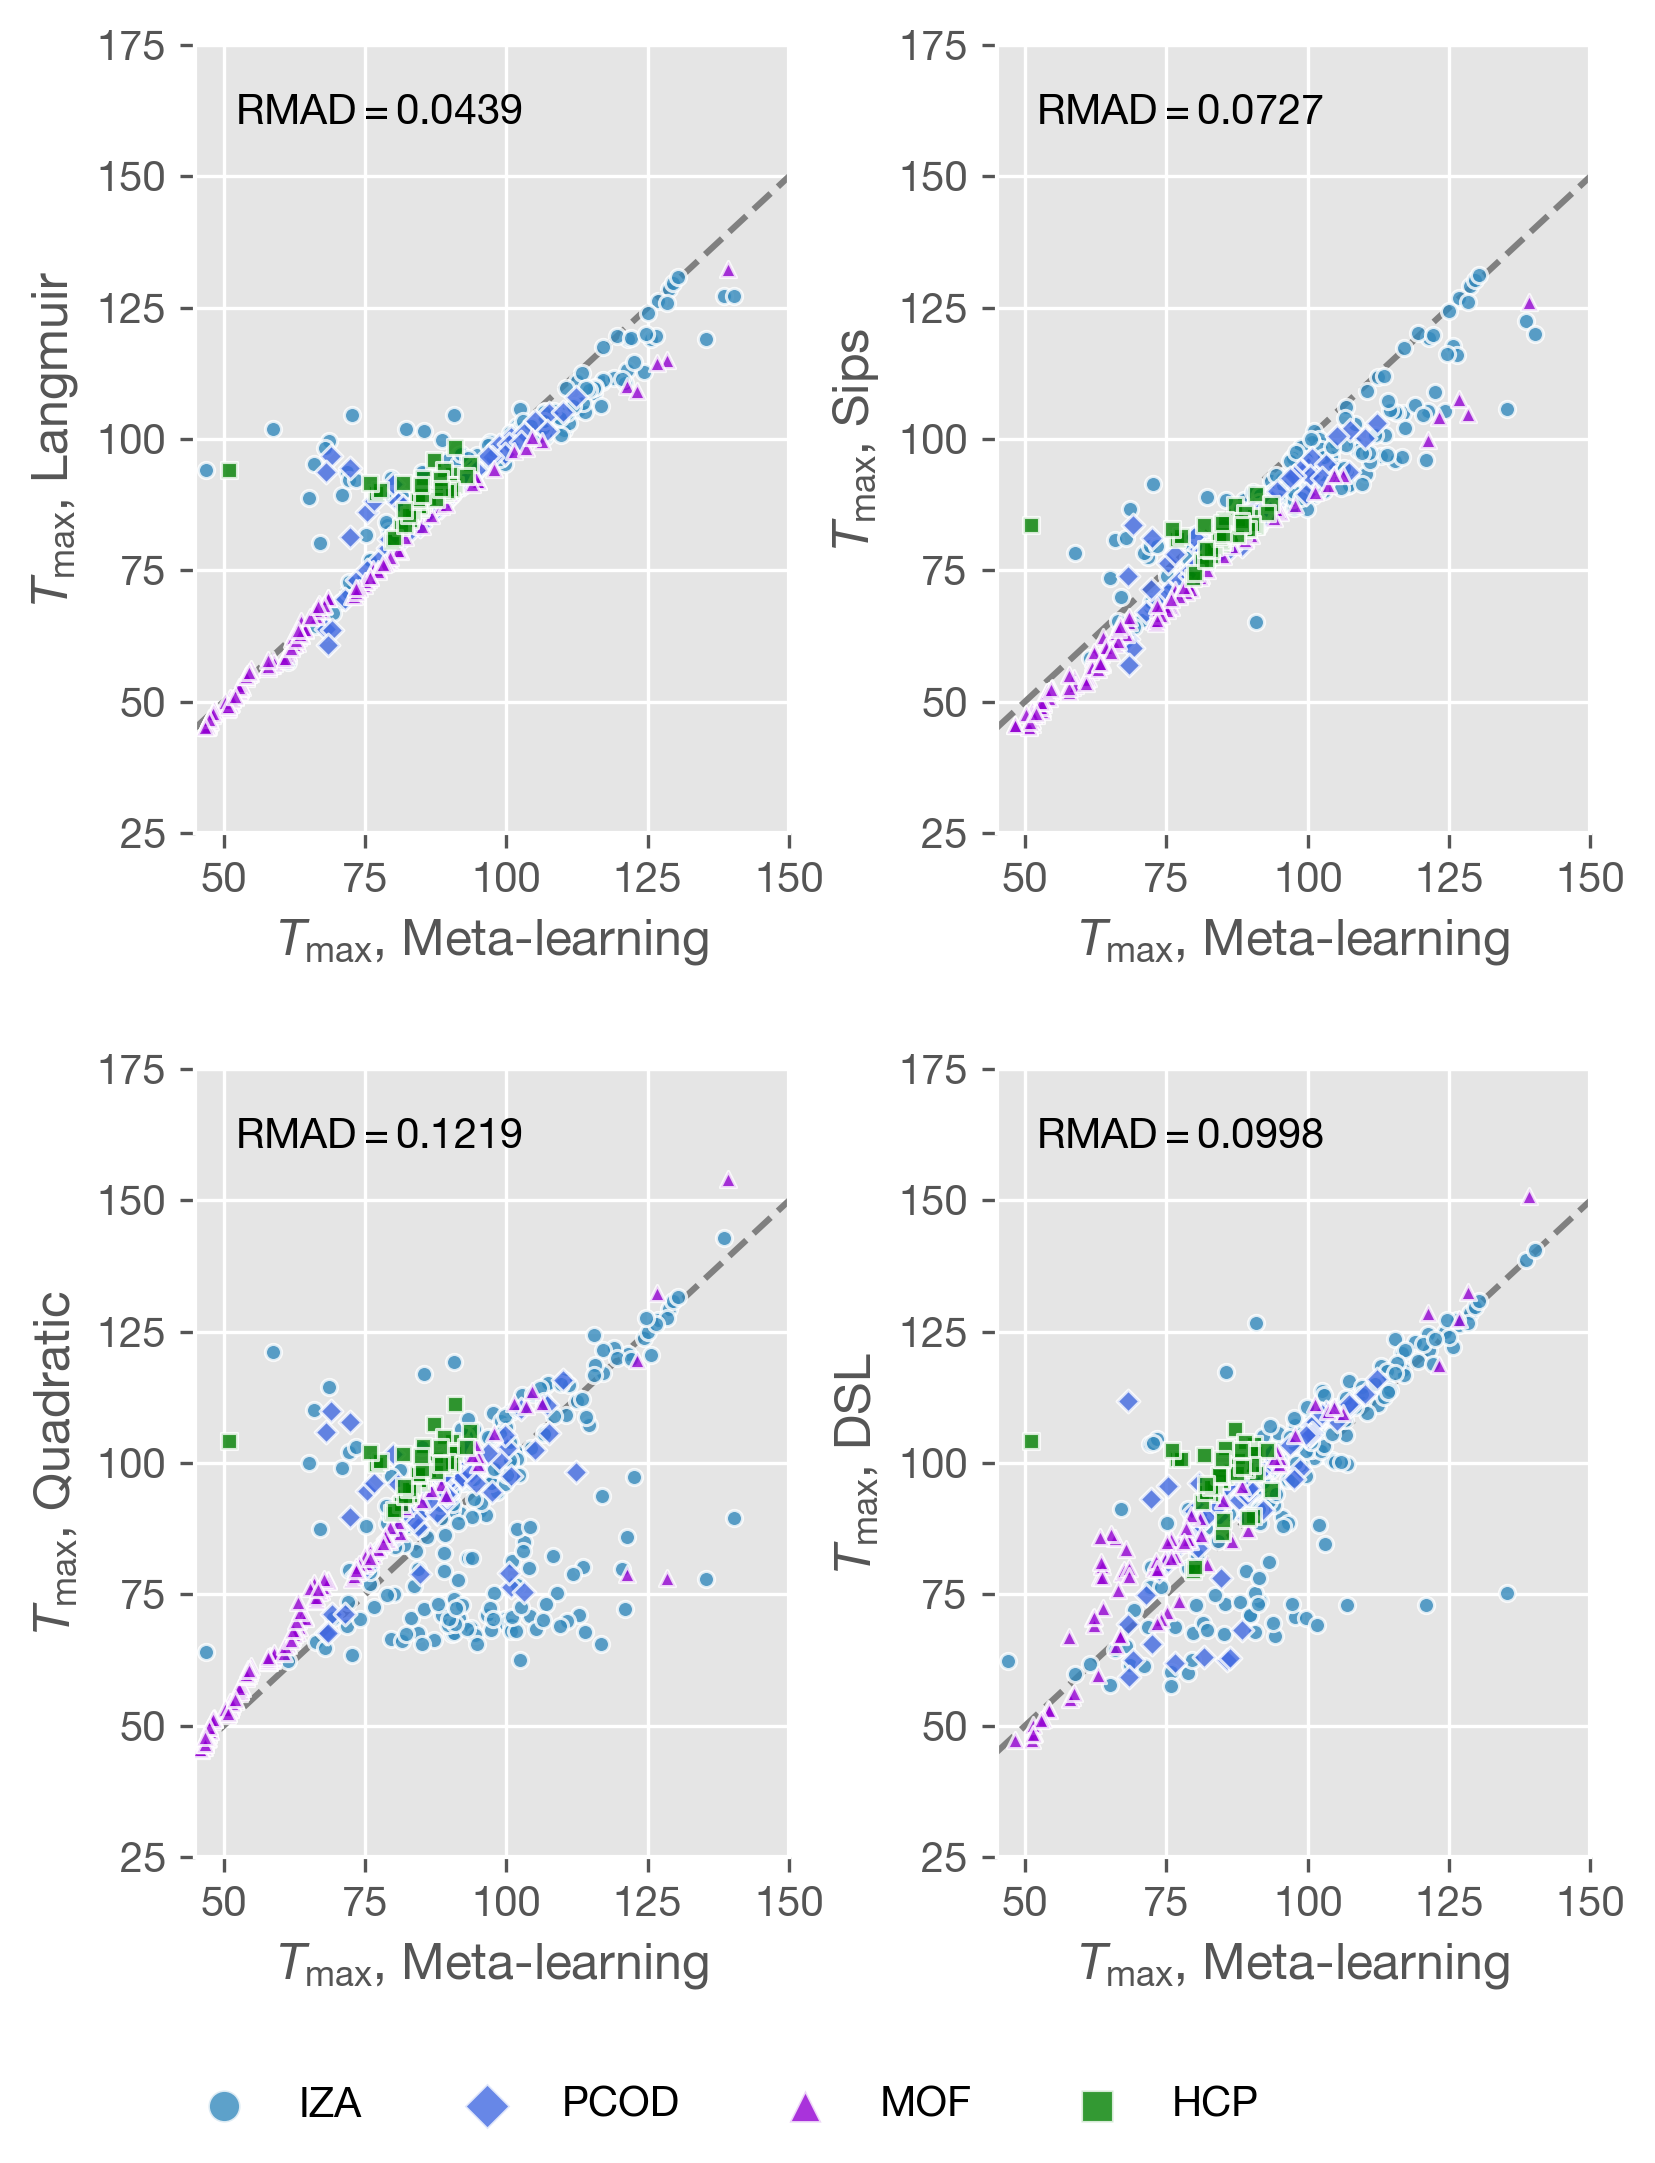

In [6]:
c1 = np.array([52,138,189]) / 255
colors = [c1, 
          rgb('royalblue'), 
          rgb('darkviolet'),
          rgb('green'),
         ]

markers = ['o', 'D', '^', 's']

fig, axes = plt.subplots(2, 2, figsize=(6,8), dpi=300)
plt.subplots_adjust(wspace=0.35, hspace=0.3)
errors = [[], [], [], []]
lines = [None, None, None, None]
for i, x in enumerate(['iza', 'pcod', 'mof', 'hcp']):
    df_temp = pd.read_csv("results/supplementary/optimal_temps_comparison_%s.csv" % x)
    for j in range(4):
        ax = axes.ravel()[j]
        xs = df_temp["Meta-learning T_max"].values
        ys = df_temp["%s T_max" % isotherm_names[j]].values
        mask = (xs > 45) & (ys > 45)
        lines[i] = ax.scatter(xs[mask], ys[mask],
                  color=colors[i], marker=markers [i],
                  edgecolor="1", s=15, linewidth=0.75, alpha=0.8, zorder=50)
        errors[j].extend(np.abs((ys[mask] - xs[mask]) / xs[mask]).tolist())

for j in range(4):
    ax = axes.ravel()[j]
    ax.set_xlim([45, 150])
    ax.set_ylim([25, 175])
    ax.set_ylabel("$T_\mathrm{max}$, %s" % isotherm_names[j])
    ax.set_xlabel("$T_\mathrm{max}$, Meta-learning")
    ax.set_xticks([50, 75, 100, 125, 150])
    ax.set_yticks([25, 50, 75, 100, 125, 150, 175])
    ax.text(52, 160, "RMAD$=$%.4f" % np.mean(errors[j]))
    ax.plot([45, 150], [45, 150], color="0.5", ls='--')
fig.legend(lines, ["IZA", "PCOD", "MOF", "HCP"], 
           loc=(0.1, 0.01), ncol=4, frameon=False, markerscale=2)

#plt.savefig('figure-S6.pdf', format='pdf', bbox_inches='tight')
plt.show()


## Figure S7

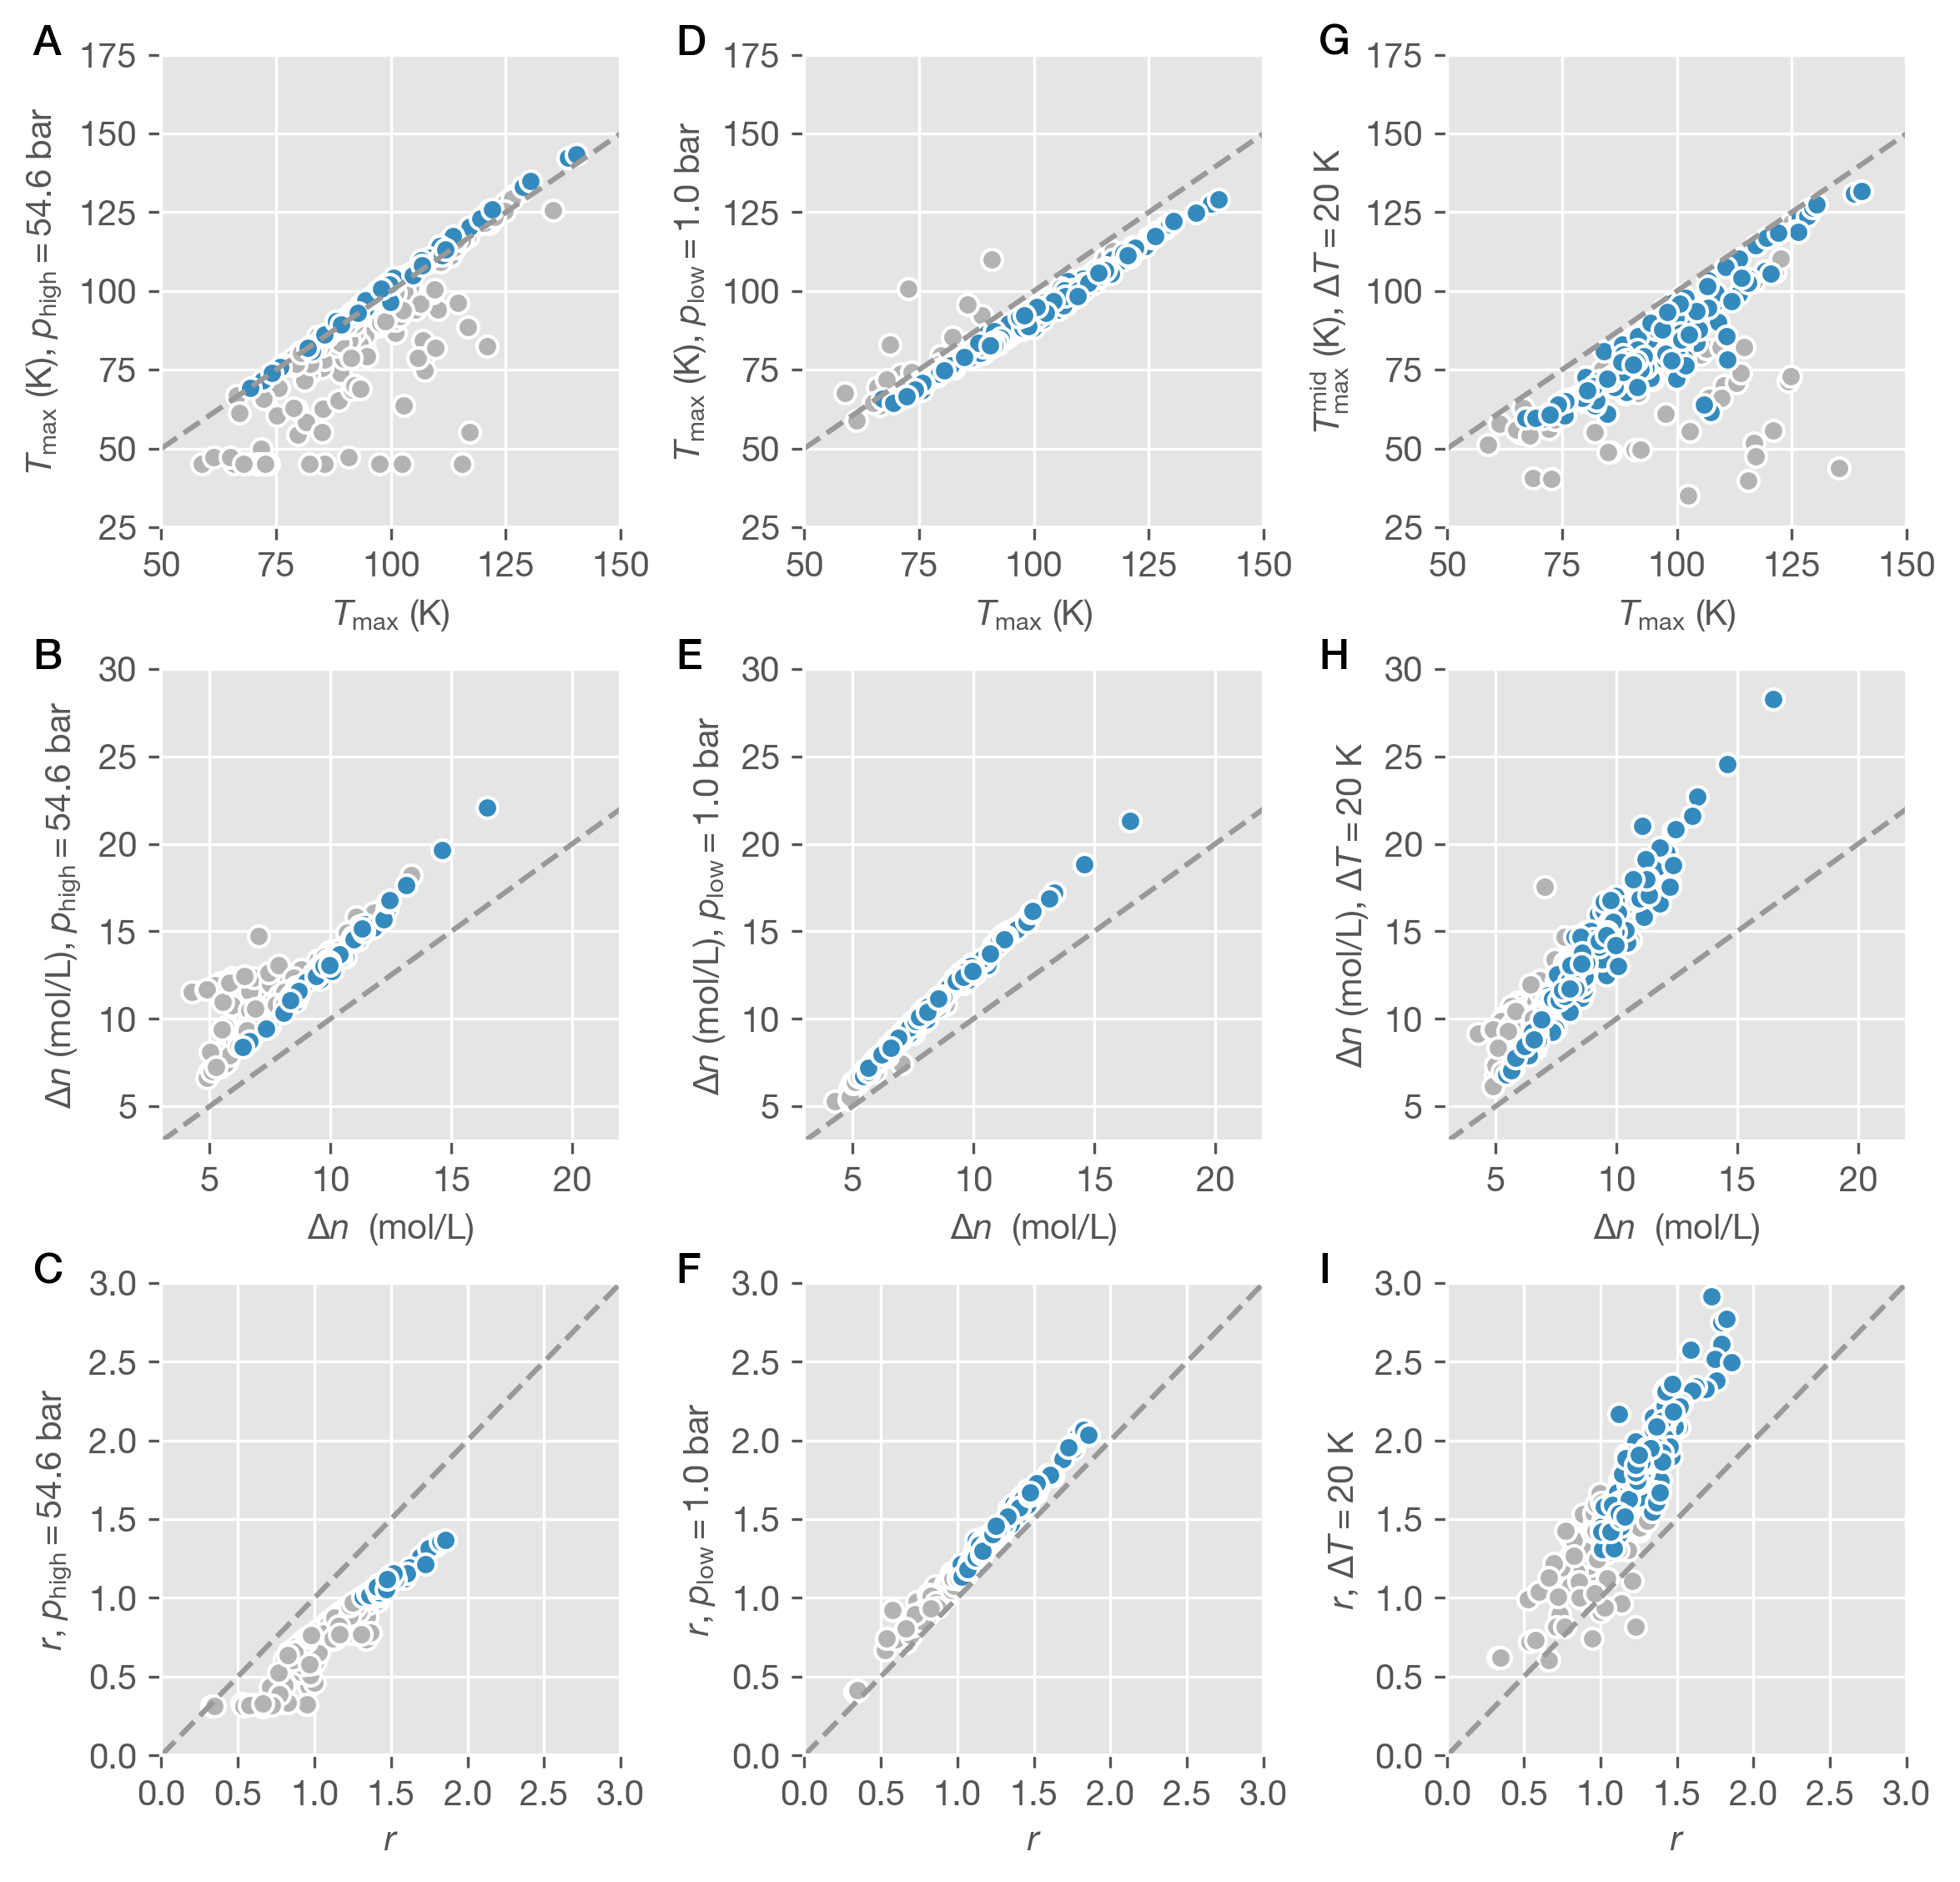

In [7]:
c1 = np.array([52,138,189]) / 255
df = pd.read_csv("results/iza/temps-p02.71-p30-f0.7-swing0.csv", index_col=0)
fig, axes = plt.subplots(3, 3, dpi=300)
fig.set_size_inches(9, 9)

def geteos(p1):
    if p1 <= 30:
        return lambda p, V, T: p * V / R / T
    elif p1 == 54.6:
        return lambda p, V, T: p * V / R / T / (0.9934 + 21.25/T - 1440/T**2)
    else:
        print("Warning: no hyrdogen EOS available for this pressure, use ideal gas law.")
        return lambda p, V, T: p * V / R / T

df_y_list = [
    pd.read_csv("results/iza/temps-p02.71-p54-f0.7-swing0.csv", index_col=0),
    pd.read_csv("results/iza/temps-p01.0-p30-f0.7-swing0.csv", index_col=0),
    pd.read_csv("results/iza/temps-p02.71-p30-f0.7-swing20.csv", index_col=0),
]

xlabel = "$T_\mathrm{max}$ (K)"
ylabel = ["$T_\mathrm{max}$ (K), $p_\mathrm{high}=54.6$ bar",
          "$T_\mathrm{max}$ (K), $p_\mathrm{low}=1.0$ bar",
          "$T_\mathrm{max}^\mathrm{mid}$ (K), $\Delta T=20$ K",
        ]
plt.subplots_adjust(wspace=0.4, hspace=0.3)

# use midpoint temperature instead of T^high
delta_t = [0, 0, 20]

for i, ax in enumerate(axes[0]):
    df_y = df_y_list[i]
    xs = df['Optimal temperature (K)']
    ys = df_y['Optimal temperature (K)']
    positives = [i for i in range(df.shape[0]) if df_y.loc[i]['Excess capacity (mol)'] > 0
                            and df.loc[i]['Excess capacity (mol)'] > 0] 
    negatives = [i for i in range(df.shape[0]) if i not in positives]

    ax.scatter(xs[negatives], ys[negatives] - delta_t[i] / 2, color='0.7', linewidth=1, edgecolor="1")
    ax.scatter(xs[positives], ys[positives] - delta_t[i] / 2, color=c1, linewidth=1, edgecolor="1")
    ax.plot([40, 160], [40, 160], ls='--', color='0.6')
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel[i], fontsize=10)
    ax.set_xlim([50, 150])
    ax.set_ylim([25, 175])

    
xlabel = "$\Delta n$  (mol/L)"
ylabel = ["$\Delta n$ (mol/L), $p_\mathrm{high}=54.6$ bar",
          "$\Delta n$ (mol/L), $p_\mathrm{low}=1.0$ bar",
          "$\Delta n$ (mol/L), $\Delta T=20$ K",
        ]
for i, ax in enumerate(axes[1]):
    df_y = df_y_list[i]
    xs = df['Tank capacity (mol)']
    ys = df_y['Tank capacity (mol)']
    positives = [i for i in range(df.shape[0]) if df_y.loc[i]['Excess capacity (mol)'] > 0
                            and df.loc[i]['Excess capacity (mol)'] > 0] 
    negatives = [i for i in range(df.shape[0]) if i not in positives]

    ax.scatter(xs[negatives], ys[negatives], color='0.7', linewidth=1, edgecolor="1")
    ax.scatter(xs[positives], ys[positives], color=c1, linewidth=1, edgecolor="1")
    ax.plot([3, 25], [3, 25], ls='--', color='0.6')
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel[i], fontsize=10)
    ax.set_xticks([5, 10, 15, 20, 25])
    ax.set_xlim([3, 22])
    ax.set_ylim([3, 30])
    #ax.set_ylim([50, 150])
    
R = 0.08314
eos = lambda T: (30 - 2.71) * 2.0158 / R / T

xlabel = "$r$"
ylabel = ["$r$, $p_\mathrm{high}=54.6$ bar",
          "$r$, $p_\mathrm{low}=1.0$ bar",
          "$r$, $\Delta T=20$ K",
        ]

n_h2 = [
    lambda T: geteos(30)(30, 2.0158, T) - geteos(2.71)(2.71, 2.0158, T),
    lambda T: geteos(54.6)(54.6, 2.0158, T) - geteos(2.71)(2.71, 2.0158, T),
    lambda T: geteos(30)(30, 2.0158, T) - geteos(1)(1, 2.0158, T),
    lambda T: geteos(30)(30, 2.0158, T) - geteos(2.71)(2.71, 2.0158, T + 20),
]

for i, ax in enumerate(axes[2]):
    df_y = df_y_list[i]
    xs = df['Tank capacity (mol)'] / np.array([n_h2[0](T) for T in df['Optimal temperature (K)']])
    ys = df_y['Tank capacity (mol)'] / np.array([n_h2[1 + i](T) for T in df_y['Optimal temperature (K)']])
    positives = [i for i in range(df.shape[0]) if df_y.loc[i]['Excess capacity (mol)'] > 0
                            and df.loc[i]['Excess capacity (mol)'] > 0] 
    negatives = [i for i in range(df.shape[0]) if i not in positives]

    ax.scatter(xs[negatives], ys[negatives], color='0.7', linewidth=1, edgecolor="1")
    ax.scatter(xs[positives], ys[positives], color=c1, linewidth=1, edgecolor="1")
    ax.plot([0, 3], [0, 3], ls='--', color='0.6')
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel[i], fontsize=10)
    ax.set_xlim([0, 3])
    ax.set_ylim([0, 3])
    ax.set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
for i, l in enumerate('ABCDEFGHI'):
    plt.text(-0.28, 1, l, transform=axes[i%3, i//3].transAxes, fontsize=12, fontweight=600)
#plt.savefig('figure-S7', bbox_inches='tight')
plt.show()

## Figure S8

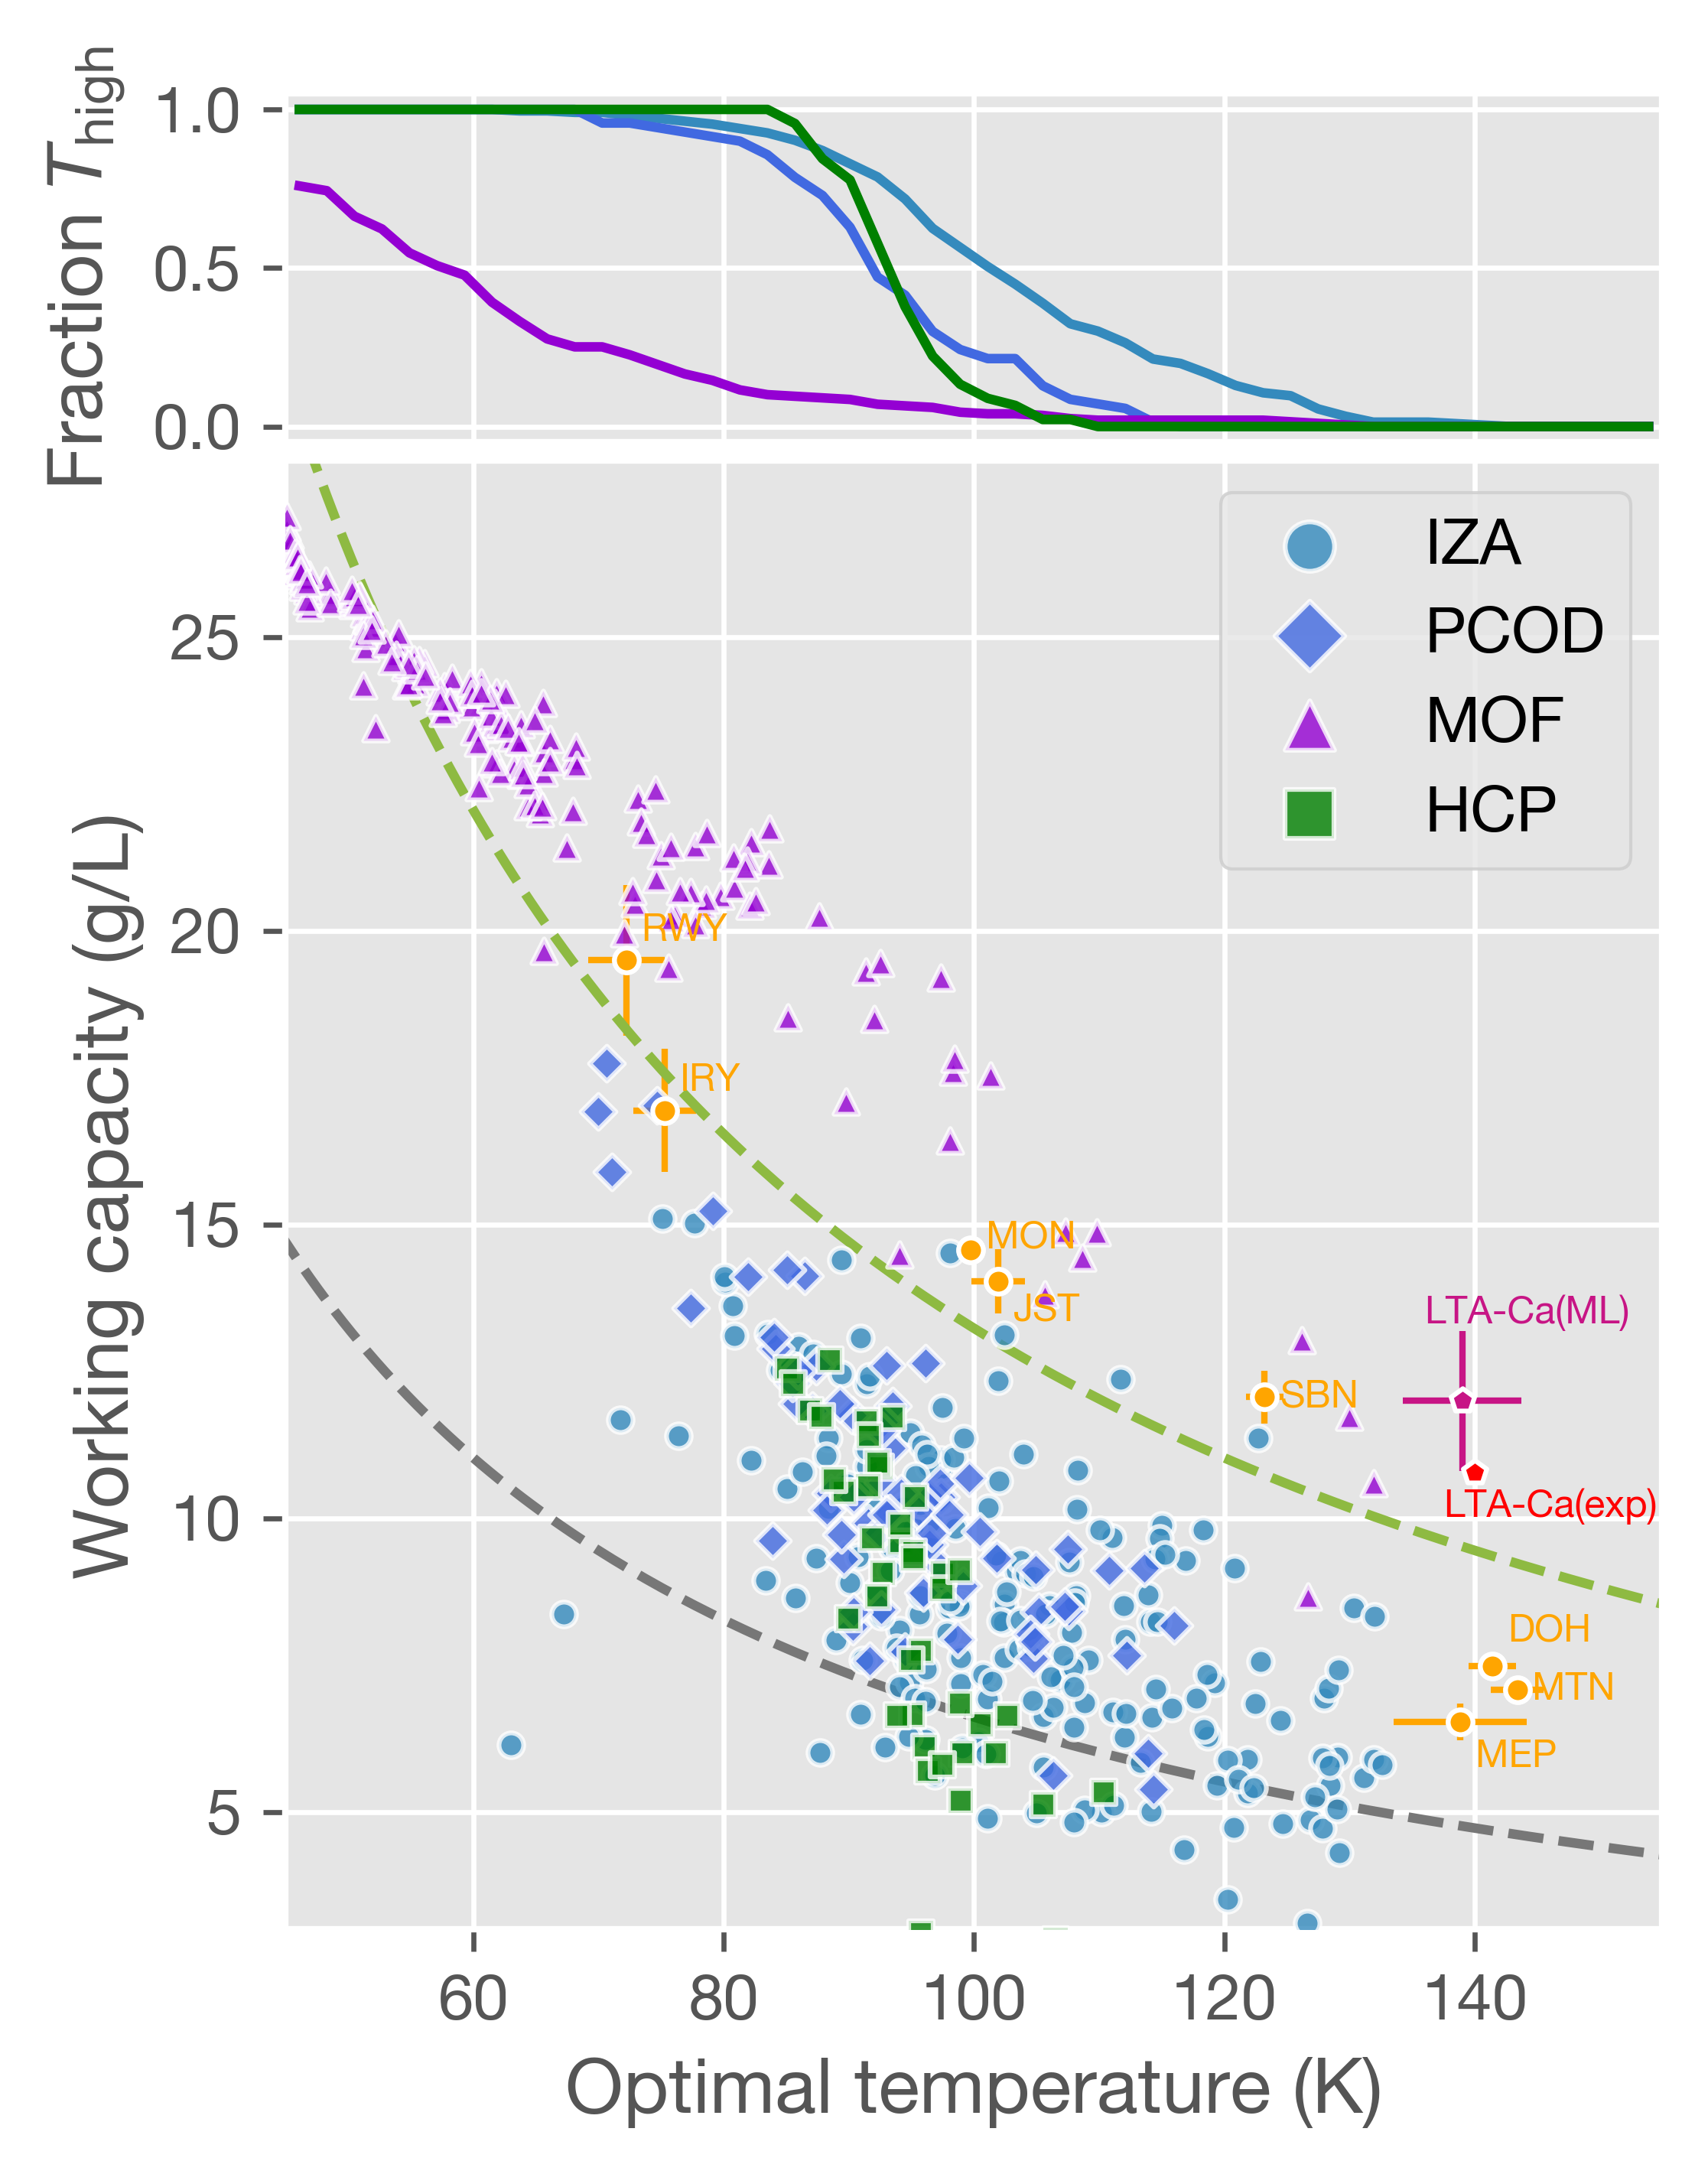

In [8]:
df_iza = pd.read_csv("results/iza/temps-p02.71-p30-f1.0-swing0.csv", index_col=0, dtype={'Zeolite': str})
df_pcod = pd.read_csv("results/pcod/temps-p02.71-p30-f1.0-swing0.csv", index_col=0, dtype={'Zeolite': str})
df_mof = pd.read_csv("results/mof/temps-p02.71-p30-f1.0-swing0.csv", index_col=0, dtype={'Zeolite': str})
df_hcp = pd.read_csv("results/hcp/temps-p02.71-p30-f1.0-swing0.csv", index_col=0, dtype={'Zeolite': str})

R = 0.08314
eos = lambda p, V, T: p * V / R / T
p1 = 30
p0 = 2.71

ylim = [3, 28]
xlim = [45, 155]

colors = [c1, 
          rgb('royalblue'), 
          rgb('darkviolet'),
          rgb('green'),
         ]

markers = ['o', 'D', '^', 's']

fig = plt.figure(figsize=(3, 4), dpi=600)
ax_main = fig.add_axes([0, 0, 1, 0.8], zorder=20)
ax_sidex = fig.add_axes([0, 0.81, 1, 0.19], zorder=10)
ax_sidex.set_xlim(xlim)
ax_sidex.set_xticklabels([])
ax_sidex.xaxis.set_ticks_position('none')
ax_sidex.set_ylabel('Fraction $T_{\mathrm{high}}$')
ax_sidex.set_yticks([0.0, 0.5, 1.0])
ax_sidex.set_yticklabels([0.0, 0.5, 1.0])


size = 15
lw = 0.75
alpha = 0.8

lines = []

for i, df in enumerate([df_iza, df_pcod, df_mof, df_hcp]):
    x = df['Optimal temperature (K)'].values
    y = df['Tank capacity (mol)'].values
    x_err = df['Optimal temperature error (K)'].values
    y_err = df['Tank capacity error (mol)'].values
    name = df['Zeolite'].values
    temp_hist, bins = np.histogram(x, bins=50, range=(xlim[0], xlim[1]))
    # convert bin edges to center of bins as x-coordinates
    bins = (bins[1:] + bins[:-1]) / 2
    # normalized histogram
    temp_hist = temp_hist / np.sum(temp_hist)
    ax_sidex.plot(bins, 1 - np.cumsum(temp_hist), color=colors[i])
    mask = df['Optimal temperature (K)'] >= 45.1
    lines.append(ax_main.scatter(x[mask], y[mask], color=colors[i], marker=markers[i], 
                                 edgecolor="1", zorder=10, s=size, linewidth=lw, alpha=alpha))
    if i == 0:
        validated = ['RWY-0', 'IRY-0', 'MON-0', 'JST-0', 'SBN-0', 'MEP-0', 'DOH-0', 'MTN-0']
        offsets = [0.5, 0.5, 0.2, -0.5, 0, -0.6, 0.6, 0]
        for i in range(len(name)):
            y_gas = (eos(p1, 2.0158, x[i]) - eos(p0, 2.0158, x[i]))
            if name[i] in validated:
                ax_main.text(x[i]+1.2, y[i]+offsets[validated.index(name[i])], name[i][:-2], 
                             fontsize=6, color='orange', rotation=0,
                             horizontalalignment='left',
                             verticalalignment='center',zorder=100)
                ax_main.scatter(x[i], y[i], color='orange', edgecolor="1", s=size, linewidth=lw, zorder=100)
                ax_main.errorbar(x[i], y[i], xerr=x_err[i], yerr=y_err[i], color="orange", marker='', ls='', linewidth=1)
                
ax_main.scatter(140, 10.77181335, color='red', edgecolor="1", s=size, linewidth=lw, zorder=120, marker='p')
ax_main.text(137.5, 10.2, "LTA-Ca(exp)",
              fontsize=6, color='red', rotation=0,
              horizontalalignment='left',
              verticalalignment='center', zorder=100)

ax_main.scatter(139.025, 12.00,color='mediumvioletred', edgecolor="1", s=size, linewidth=lw, zorder=120, marker='p')
ax_main.errorbar(139.025, 12.00, xerr=4.7346,yerr=1.1909, color="mediumvioletred", marker='', 
                                 ls='', linewidth=1, zorder=100)

ax_main.text(136, 13.5, "LTA-Ca(ML)",
              fontsize=6, color='mediumvioletred', rotation=0,
              horizontalalignment='left',
              verticalalignment='center', zorder=100)

x_line = np.linspace(30,160,200)
y_line = (eos(p1, 2.0158, x_line) - eos(p0, 2.0158, x_line))
ax_main.plot(x_line, y_line, color='C3', ls='--')
ax_main.plot(x_line, 2*y_line, color='C5', ls='--')
ax_main.set_xlim(xlim)
ax_main.set_ylim(ylim)
ax_main.set_xlabel('Optimal temperature (K)')
ax_main.set_ylabel('Working capacity (g/L)')
ax_main.legend(lines, ['IZA', 'PCOD', 'MOF', 'HCP'], loc='best', markerscale=2)
#plt.savefig('figure-S6.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Figure S9
**Note:** The neural network predicting structural parameters is trained in this cell. The resulting $R^2$ values will be slightly different from the manuscript due to random initialization.

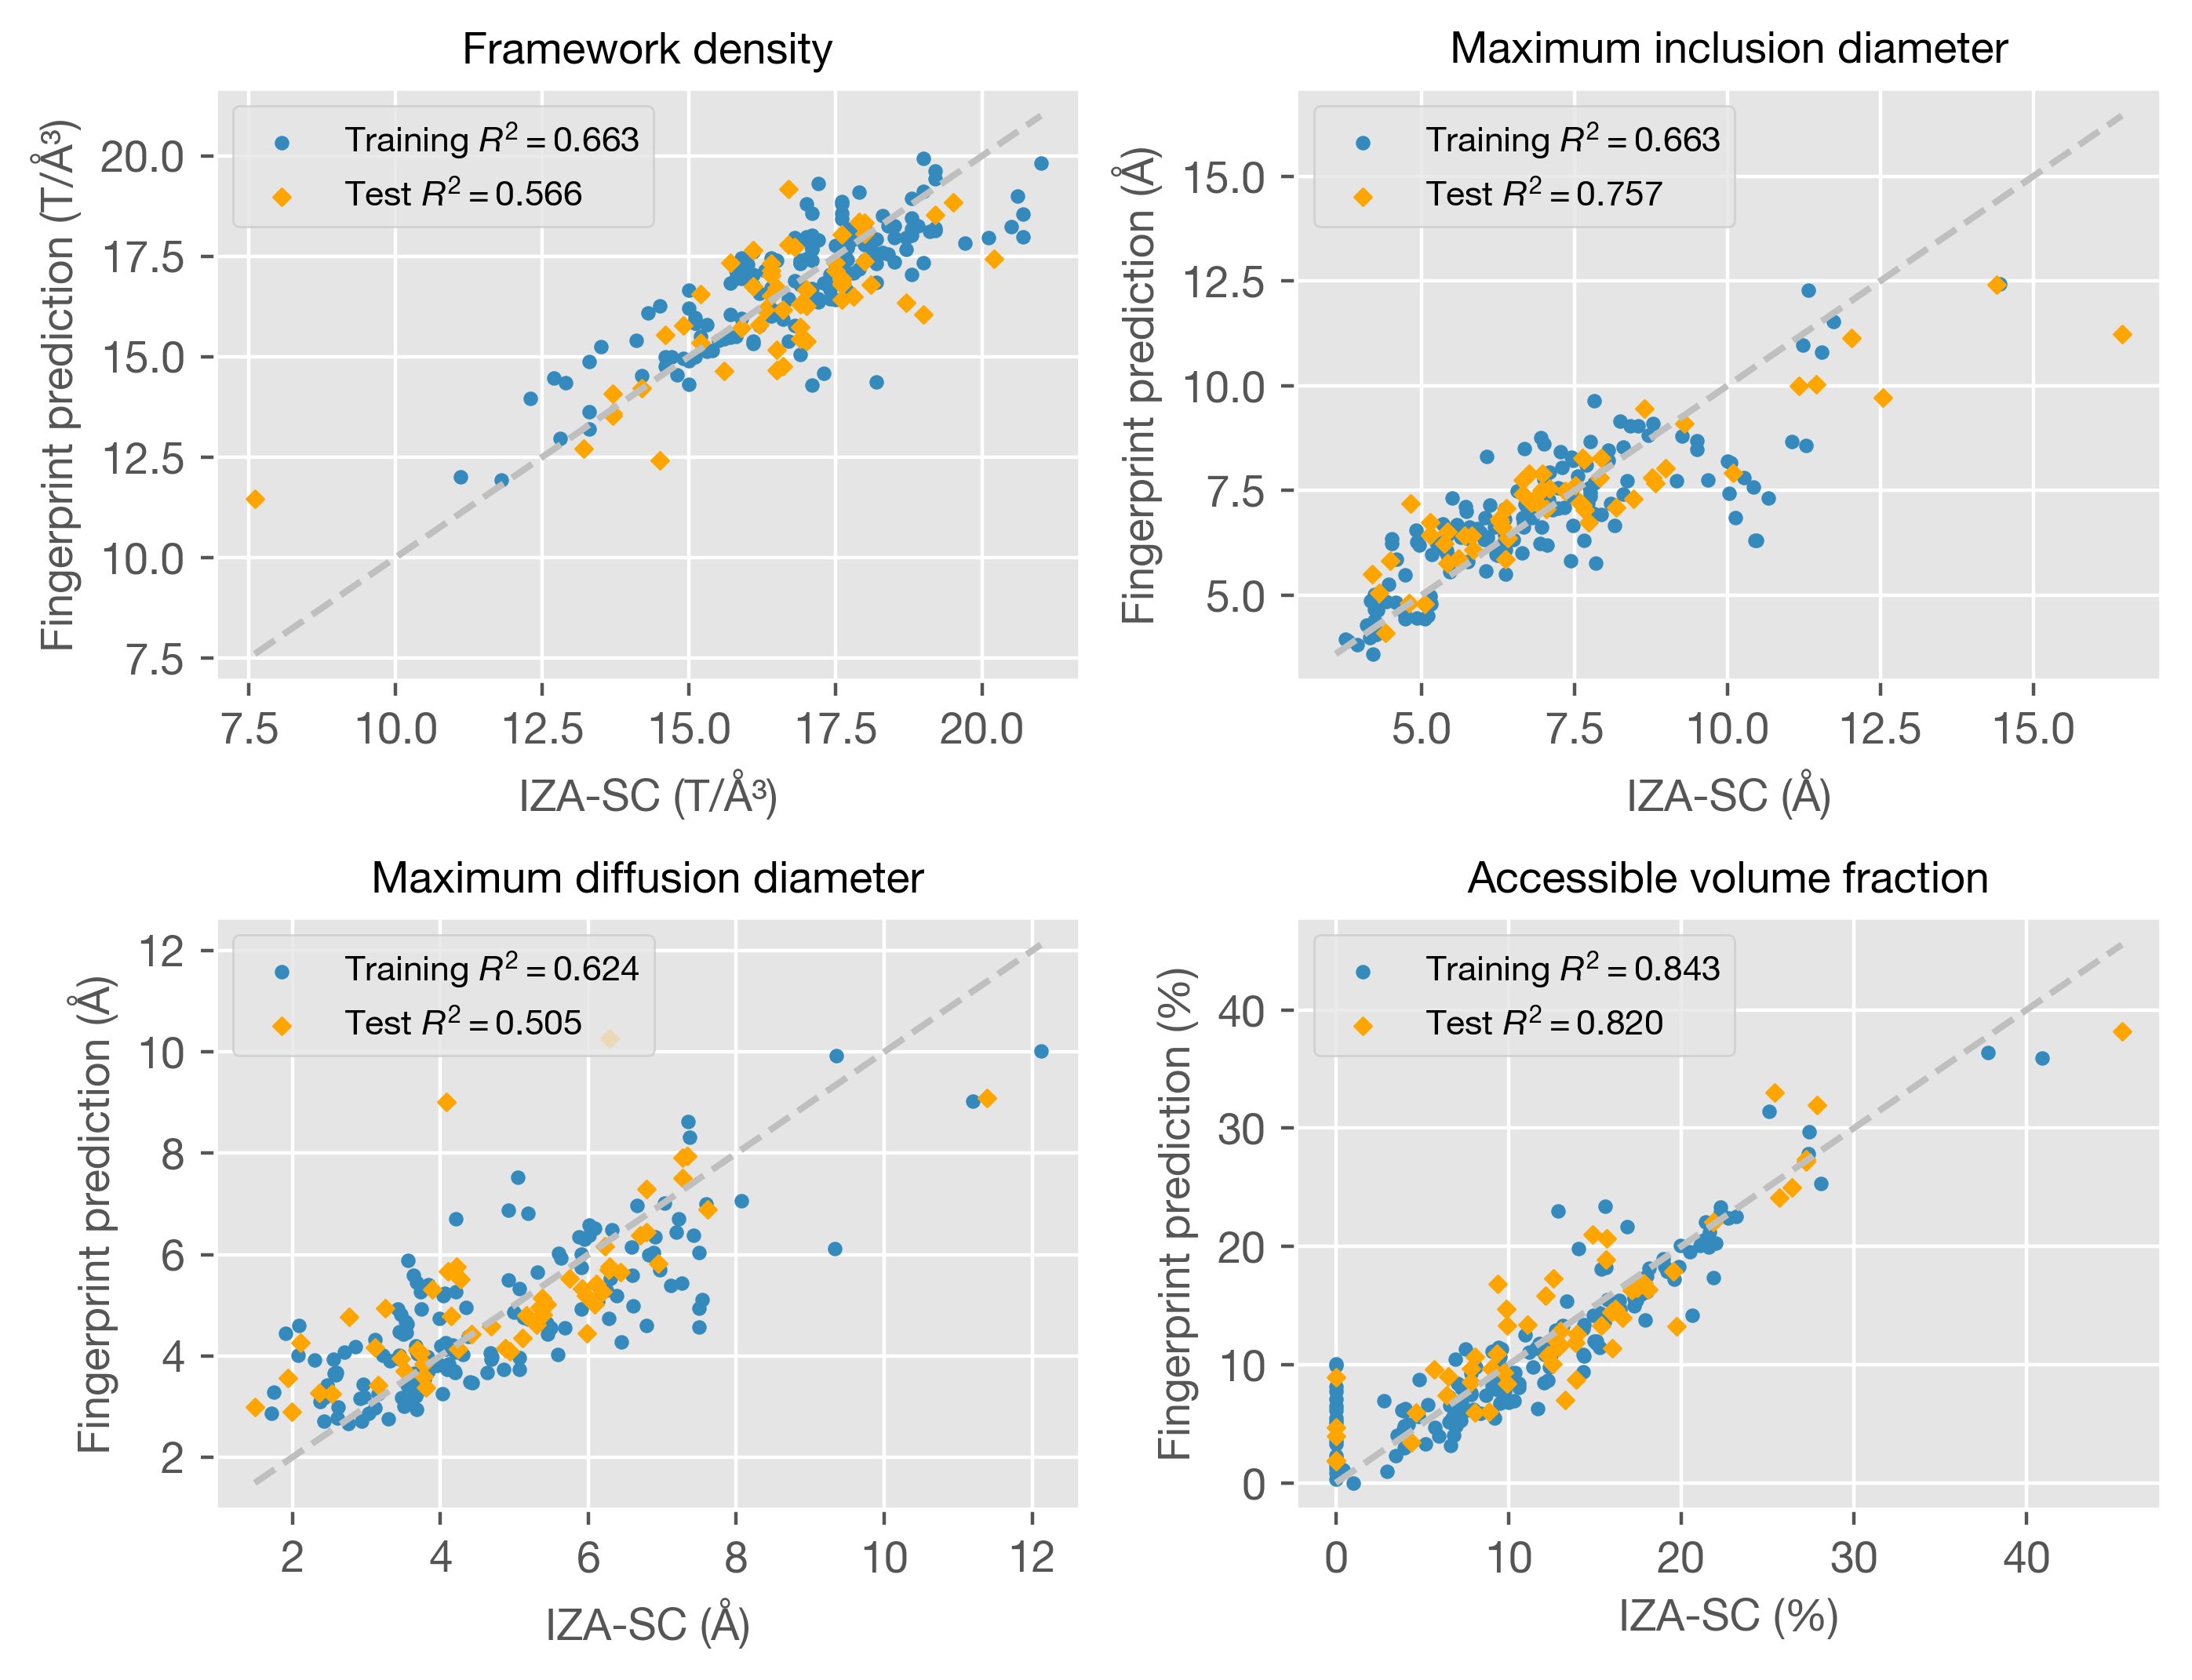

In [9]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

zeolite_names = [x.split("-")[0] for x in np.genfromtxt("../data/iza/names.csv", dtype=str)]
fingerprints = np.loadtxt("results/iza/nn-regular.csv", delimiter=",")[:, :-1] # last column stored is mean square error
df_izasc = pd.read_csv("results/supplementary/IZA-parameters.csv", index_col=0).set_index("Code")
df_izasc["Max diffusion diameter"] = np.max(df_izasc.iloc[:, 4:7], axis=1)

prop = df_izasc.loc[zeolite_names]
Y_raw = prop[['Framework density', 'Max inclusion diameter', 'Max diffusion diameter', 'Accessible volume (%)']].values
title = ['Framework density', 'Maximum inclusion diameter', 'Maximum diffusion diameter', 'Accessible volume fraction']
units = ['T/Å³', 'Å', 'Å', '%']

n = 160
# normalize
Y_max = np.max(Y_raw[:n], axis=0)
X, Y = fingerprints, Y_raw
Y = Y / Y_max
X_train, Y_train = X[:n], Y[:n]
X_test, Y_test = X[n:], Y[n:]


np.random.seed(5)
model = MLPRegressor(hidden_layer_sizes=(8, 8, 8), activation='relu', solver='lbfgs', max_iter=10000)
model.fit(X_train, Y_train)
Y_train_pred = np.clip(model.predict(X_train), 0, np.inf)
Y_test_pred = np.clip(model.predict(X_test), 0, np.inf)

fig, axes = plt.subplots(2, 2, figsize=(8, 6), dpi=400)
plt.subplots_adjust(wspace=0.25, hspace=0.4)
for i, ax in enumerate(axes.ravel()):
    low = np.min(np.hstack([Y_train[:, i], Y_train_pred[:, i], Y_test[:, i],  Y_test_pred[:, i]])) * Y_max[i]
    high = np.max(np.hstack([Y_train[:, i], Y_train_pred[:, i], Y_test[:, i],  Y_test_pred[:, i]])) * Y_max[i]
    ax.scatter(Y_train[:, i] * Y_max[i], Y_train_pred[:, i] * Y_max[i], color="C1", s=8)
    ax.scatter(Y_test[:, i] * Y_max[i], Y_test_pred[:, i] * Y_max[i], color="orange", s=8, marker='D')
    r2_train = r2_score(Y_train[:, i], Y_train_pred[:, i])
    r2_test = r2_score(Y_test[:, i], Y_test_pred[:, i])
    ax.legend(["Training $R^2=%.3f$" % r2_train, "Test $R^2=%.3f$" % r2_test], loc="upper left", fontsize=8)
    ax.plot([low, high], [low, high], color="0.75", ls='--')
    ax.set_xlabel("IZA-SC (%s)" % units[i], fontsize=10)
    ax.set_ylabel("Fingerprint prediction (%s)" % units[i], fontsize=10)
    ax.set_title(title[i], fontsize=10)
#plt.savefig("figure-S9.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Figure S10

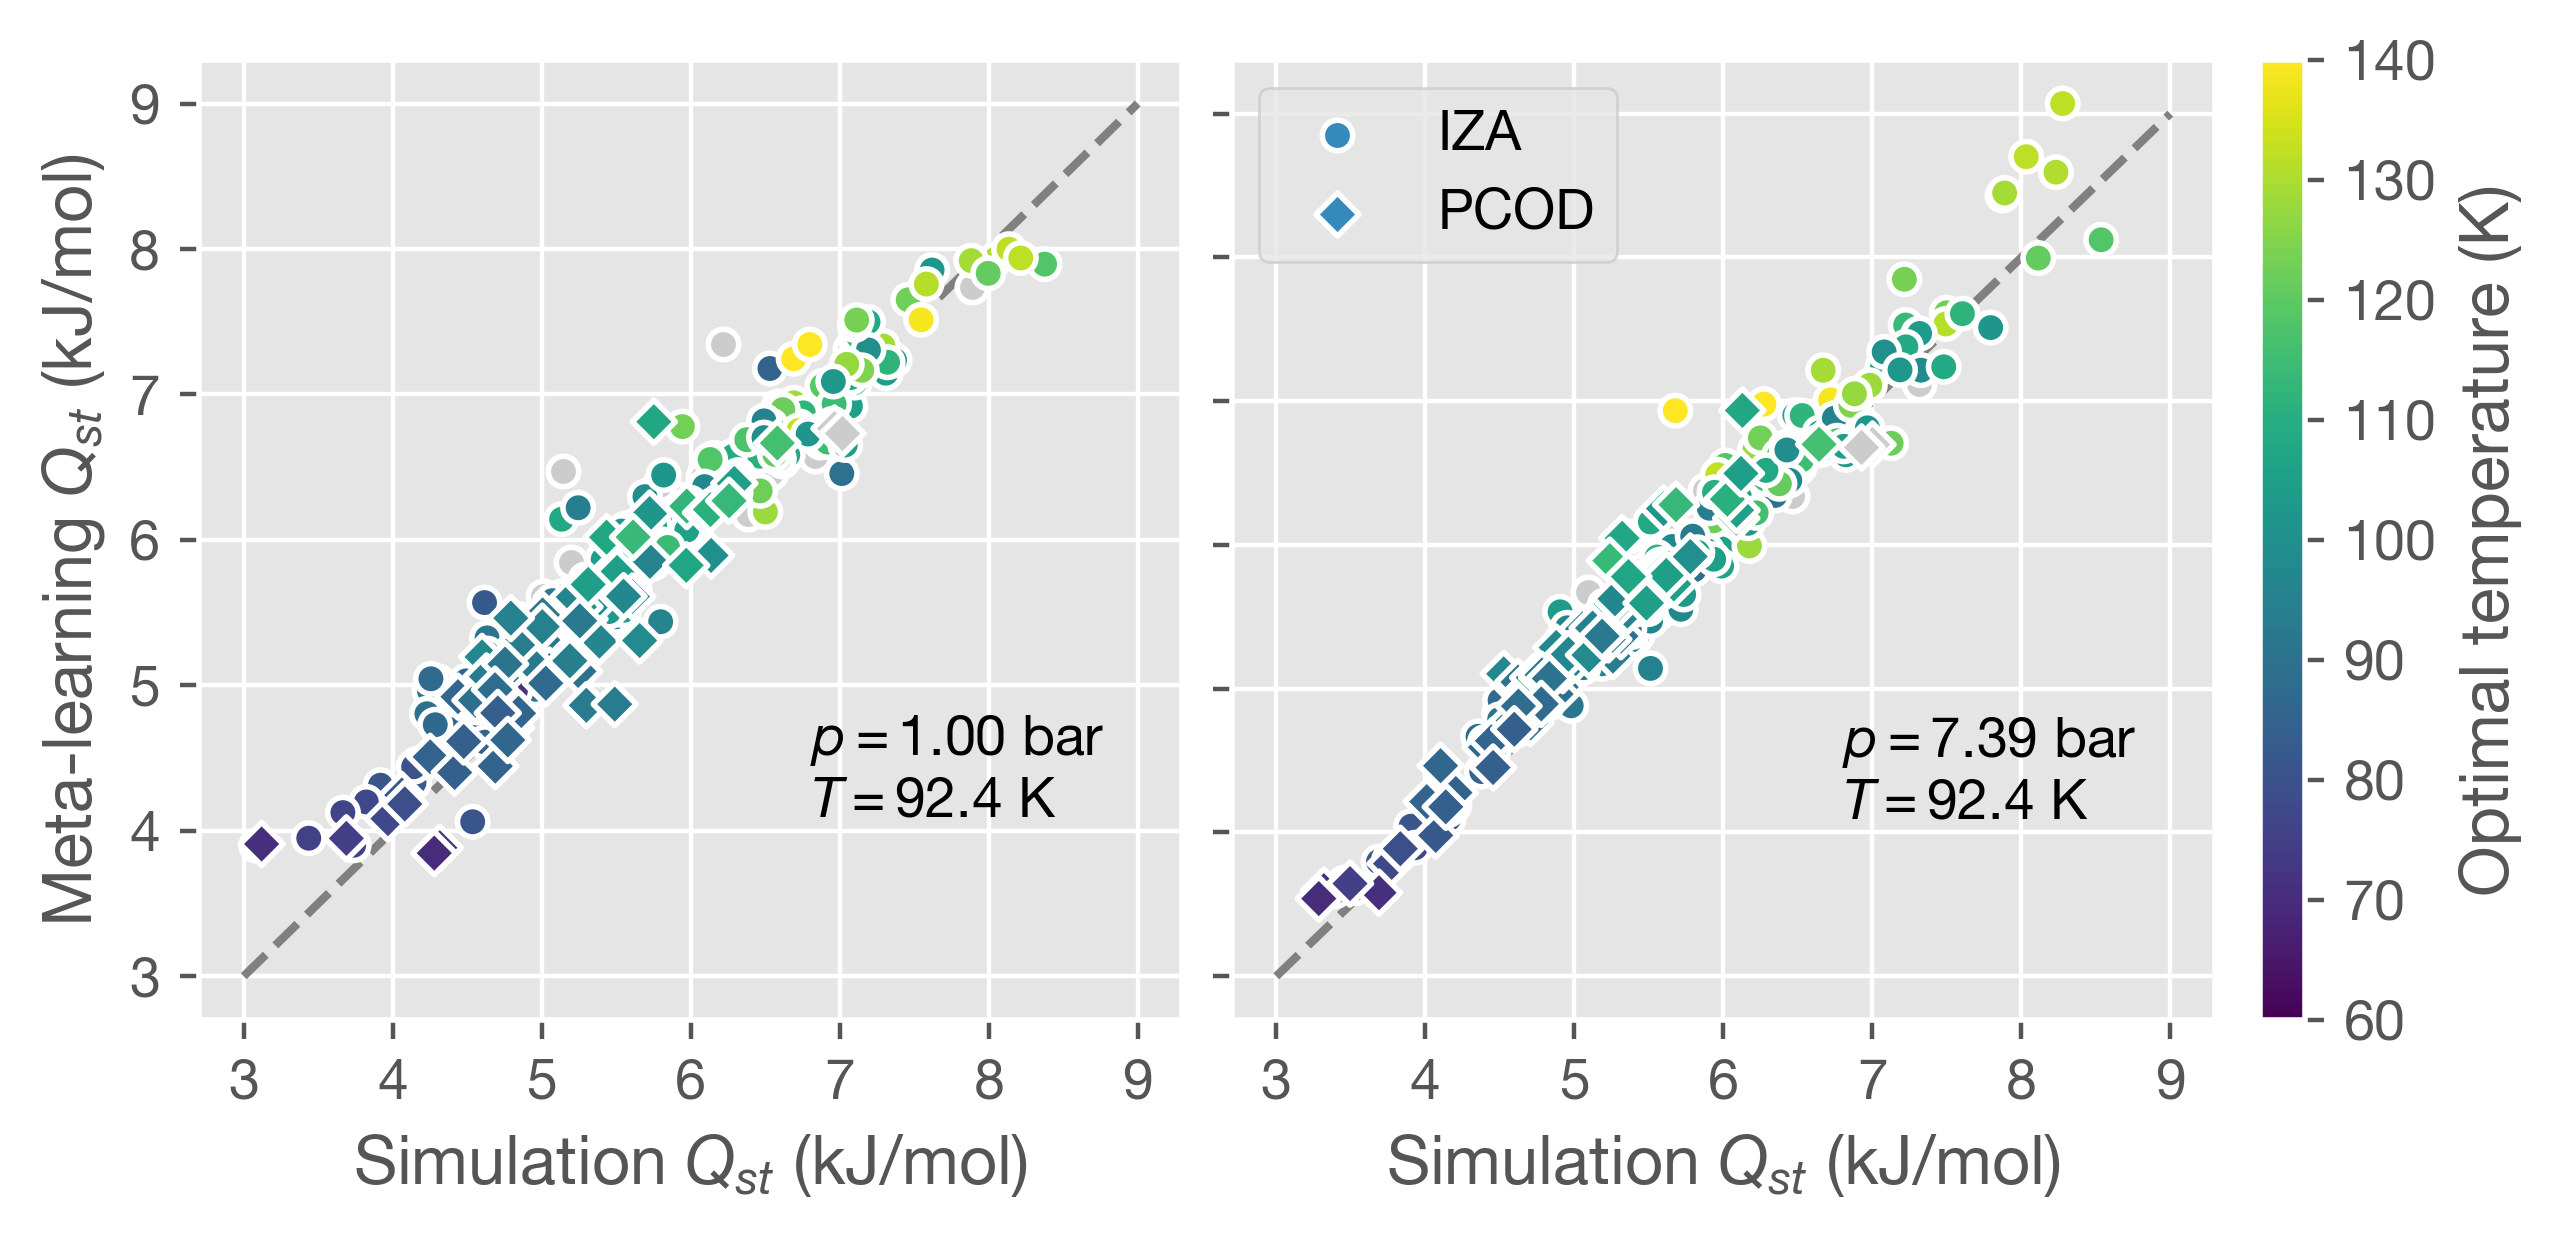

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(5.6, 3), dpi=400)
plt.subplots_adjust(right=0.9, top=0.9, bottom=0.1, left=0, wspace=0.05)

paths = ['results/iza', 'results/pcod']
df_list = [df_iza, df_pcod]

pids = [0, 2]
tids = [1, 1]
pressures = [1.0, 2.71, 7.39, 20.09, 30.0, 54.60, 148.4, 403.4]
temperatures = [77.0, 92.4, 110.88, 133.06, 159.67, 191.60, 229.92, 275.90]


for j, ax in enumerate(axes):
    pid = pids[j]
    tid = tids[j]
    key = 'P%d-T%d' % (pid, tid)
    plots = []
    norm = plt.Normalize(60, 140)
    for i in range(2):
        heat_sim = np.load("%s/heat-sim.npy" % paths[i]) 
        df = pd.read_csv('%s/heat-%s-ml.csv'% (paths[i], key), dtype={'Zeolite': str}, index_col=0)
        df = df.merge(df_list[i], on="Zeolite").sort_values("Zeolite")
        df["q_st"] = heat_sim[:, pid, tid, 0]
        mask = df['Excess capacity (mol)'] <= 0
        ax.scatter(-df['q_st'].loc[mask], df.loc[mask, df.columns.str.startswith("Heat of adsorption (")],
                    color='0.8', linewidth=1, s=30, edgecolor='1', marker=markers[i], zorder=20)
        mask = df['Excess capacity (mol)'] > 0
        plots.append(ax.scatter(-df['q_st'].loc[mask], df.loc[mask, df.columns.str.startswith("Heat of adsorption (")],
                    c=df['Optimal temperature (K)'].loc[mask], 
                                 linewidth=1, s=30, edgecolor='1', marker=markers[i], zorder=20, norm=norm))
    ax.set_xlabel("Simulation $Q_{st}$ (kJ/mol)")
    ax.plot([3, 9], [3, 9], color="0.5", ls='--')
    ax.set_xticks([3,4,5,6,7,8,9])
    ax.set_yticks([3,4,5,6,7,8,9])
    ax.text(6.8, 4.1, "$p=%.2f$ bar\n$T=%.1f$ K" % (pressures[pid], temperatures[tid]),
            horizontalalignment="left")
    #plt.savefig('fig6.pdf', bbox_inches='tight', format='pdf')
axes[0].set_ylabel("Meta-learning $Q_{st}$ (kJ/mol)")
axes[1].set_yticklabels([])
axes[1].legend(plots, ['IZA', 'PCOD'])
cax = fig.add_axes((0.92, 0.1, 0.02, 0.8))
fig.colorbar(plots[1], cax=cax, label='Optimal temperature (K)')
#plt.savefig("figure-S10.pdf", format='pdf', bbox_inches="tight")
plt.show()

## Figure S11

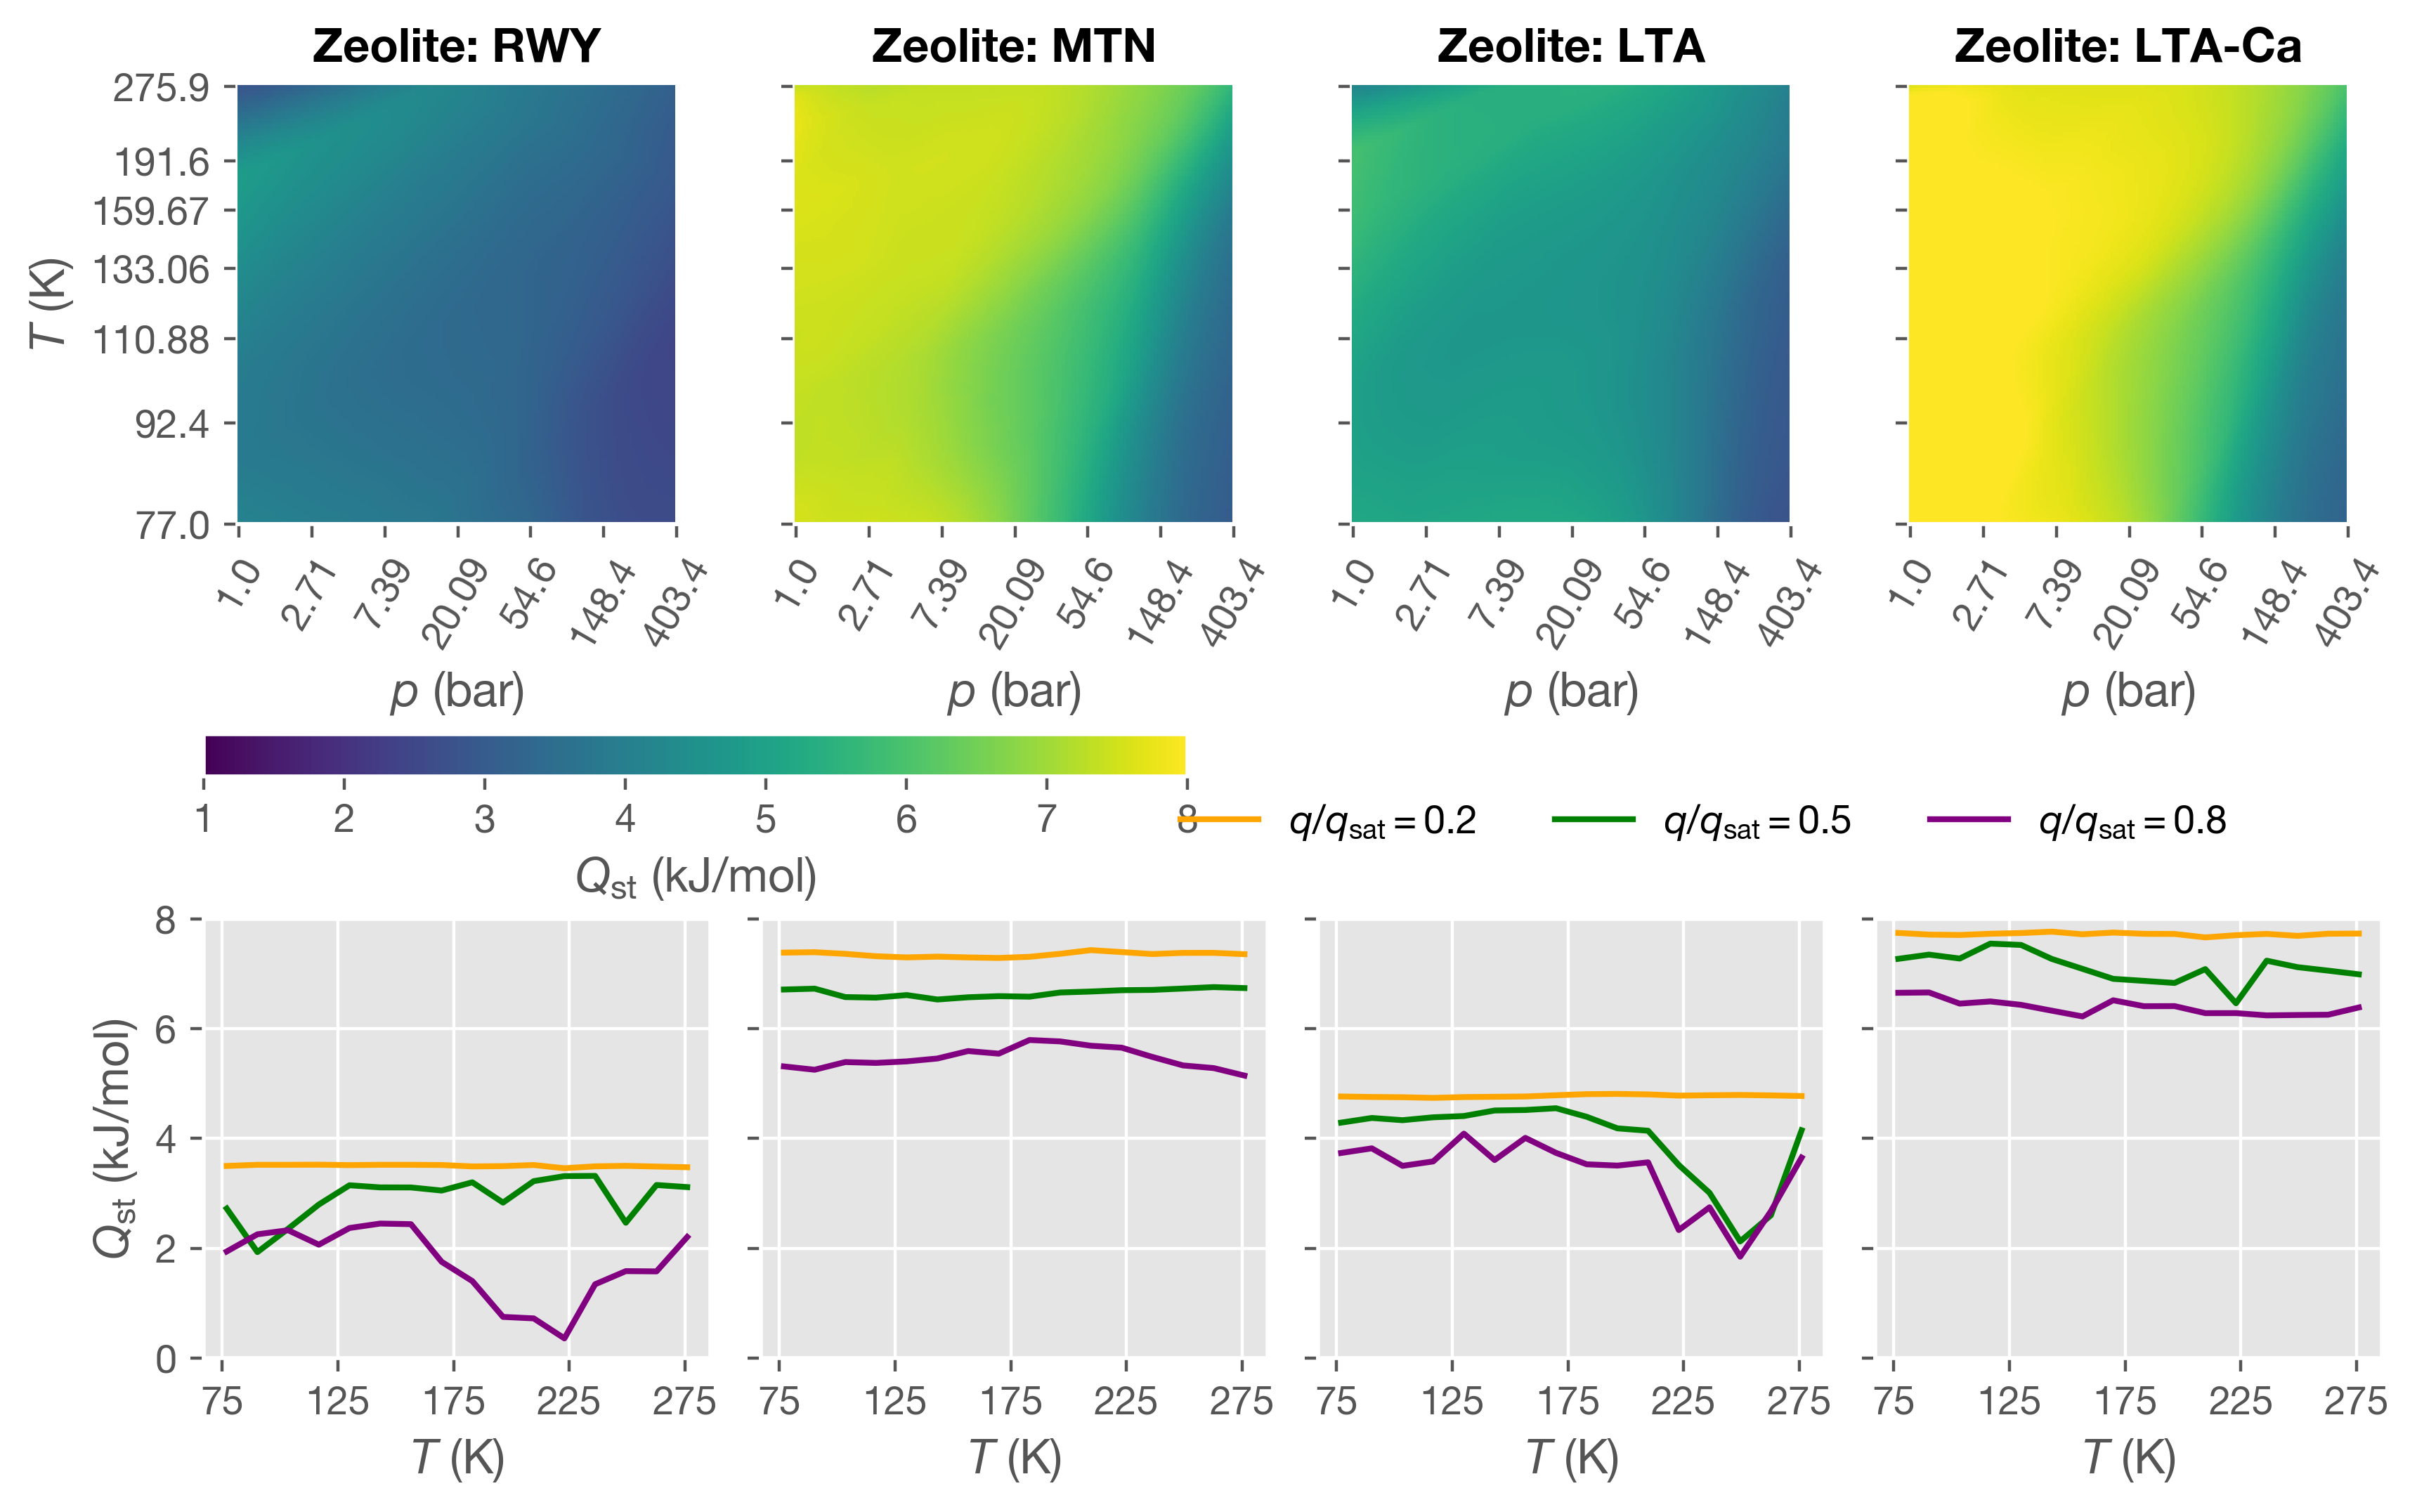

In [11]:
zeolites = ["RWY", "MTN", "LTA", "LTA-Ca"]

fig, axes = plt.subplots(2, 4, figsize=(10, 6), dpi=400)
plt.subplots_adjust(wspace=0.10, hspace=0.9)

ts = np.linspace(77, 275.9, 16, dtype=np.float32)
qst_heatmap = np.load("results/supplementary/qst_heatmap.npy")
qst_temp_dependence = np.load("results/supplementary/qst_temp_dependence.npy")

curve_colors = ["orange", "green", "purple"]
p_label = np.array([1.0, 2.71, 7.39, 20.09, 54.60, 148.4, 403.4])
t_label = np.array([77.0, 92.4, 110.88, 133.06, 159.67, 191.60, 275.90])
t_ticks = (1 / t_label - 1 / 275.9) / (1 / 77 - 1 / 275.9)

norm = plt.Normalize(1, 8)

for i in range(4):
    plot = axes[0, i].imshow(qst_heatmap[i], zorder=100, norm=norm)
    axes[0, i].set_xlabel("$p$ (bar)")
    axes[0, i].set_xticks(np.log(p_label) / 6 * 128)
    axes[0, i].set_xticklabels(p_label, rotation=60)
    axes[0, i].set_yticks(t_ticks * 128)
    axes[0, i].set_title("Zeolite: %s" % zeolites[i], fontsize=12, fontweight="bold")
    if i == 0:
        axes[0, i].set_yticklabels(t_label)
        axes[0, i].set_ylabel("$T$ (K)")
    else:
        axes[0, i].set_yticklabels([]) 
    for j in range(3):
        axes[1, i].plot(ts, qst_temp_dependence[i, j], color=curve_colors[j])
    axes[1, i].set_ylim([0, 8])
    axes[1, i].set_xticks([75, 125, 175, 225, 275])
    axes[1, i].set_xlabel("$T$ (K)")
    if i == 0:
        axes[1, i].set_ylabel("$Q_\mathrm{st}$ (kJ/mol)")
    else:
        axes[1, i].set_yticklabels([])
        
cax = fig.add_axes((0.125, 0.47, 0.35, 0.025))
fig.colorbar(plot, cax=cax, label='$Q_\mathrm{st}$ (kJ/mol)', orientation="horizontal")
fig.legend(['$q/q_\mathrm{sat}=0.2$', '$q/q_\mathrm{sat}=0.5$', '$q/q_\mathrm{sat}=0.8$'], frameon=False, 
           loc='lower left', bbox_to_anchor=(0.46, 0.41), ncol=3)
#plt.savefig("figure-S11.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Figure S12

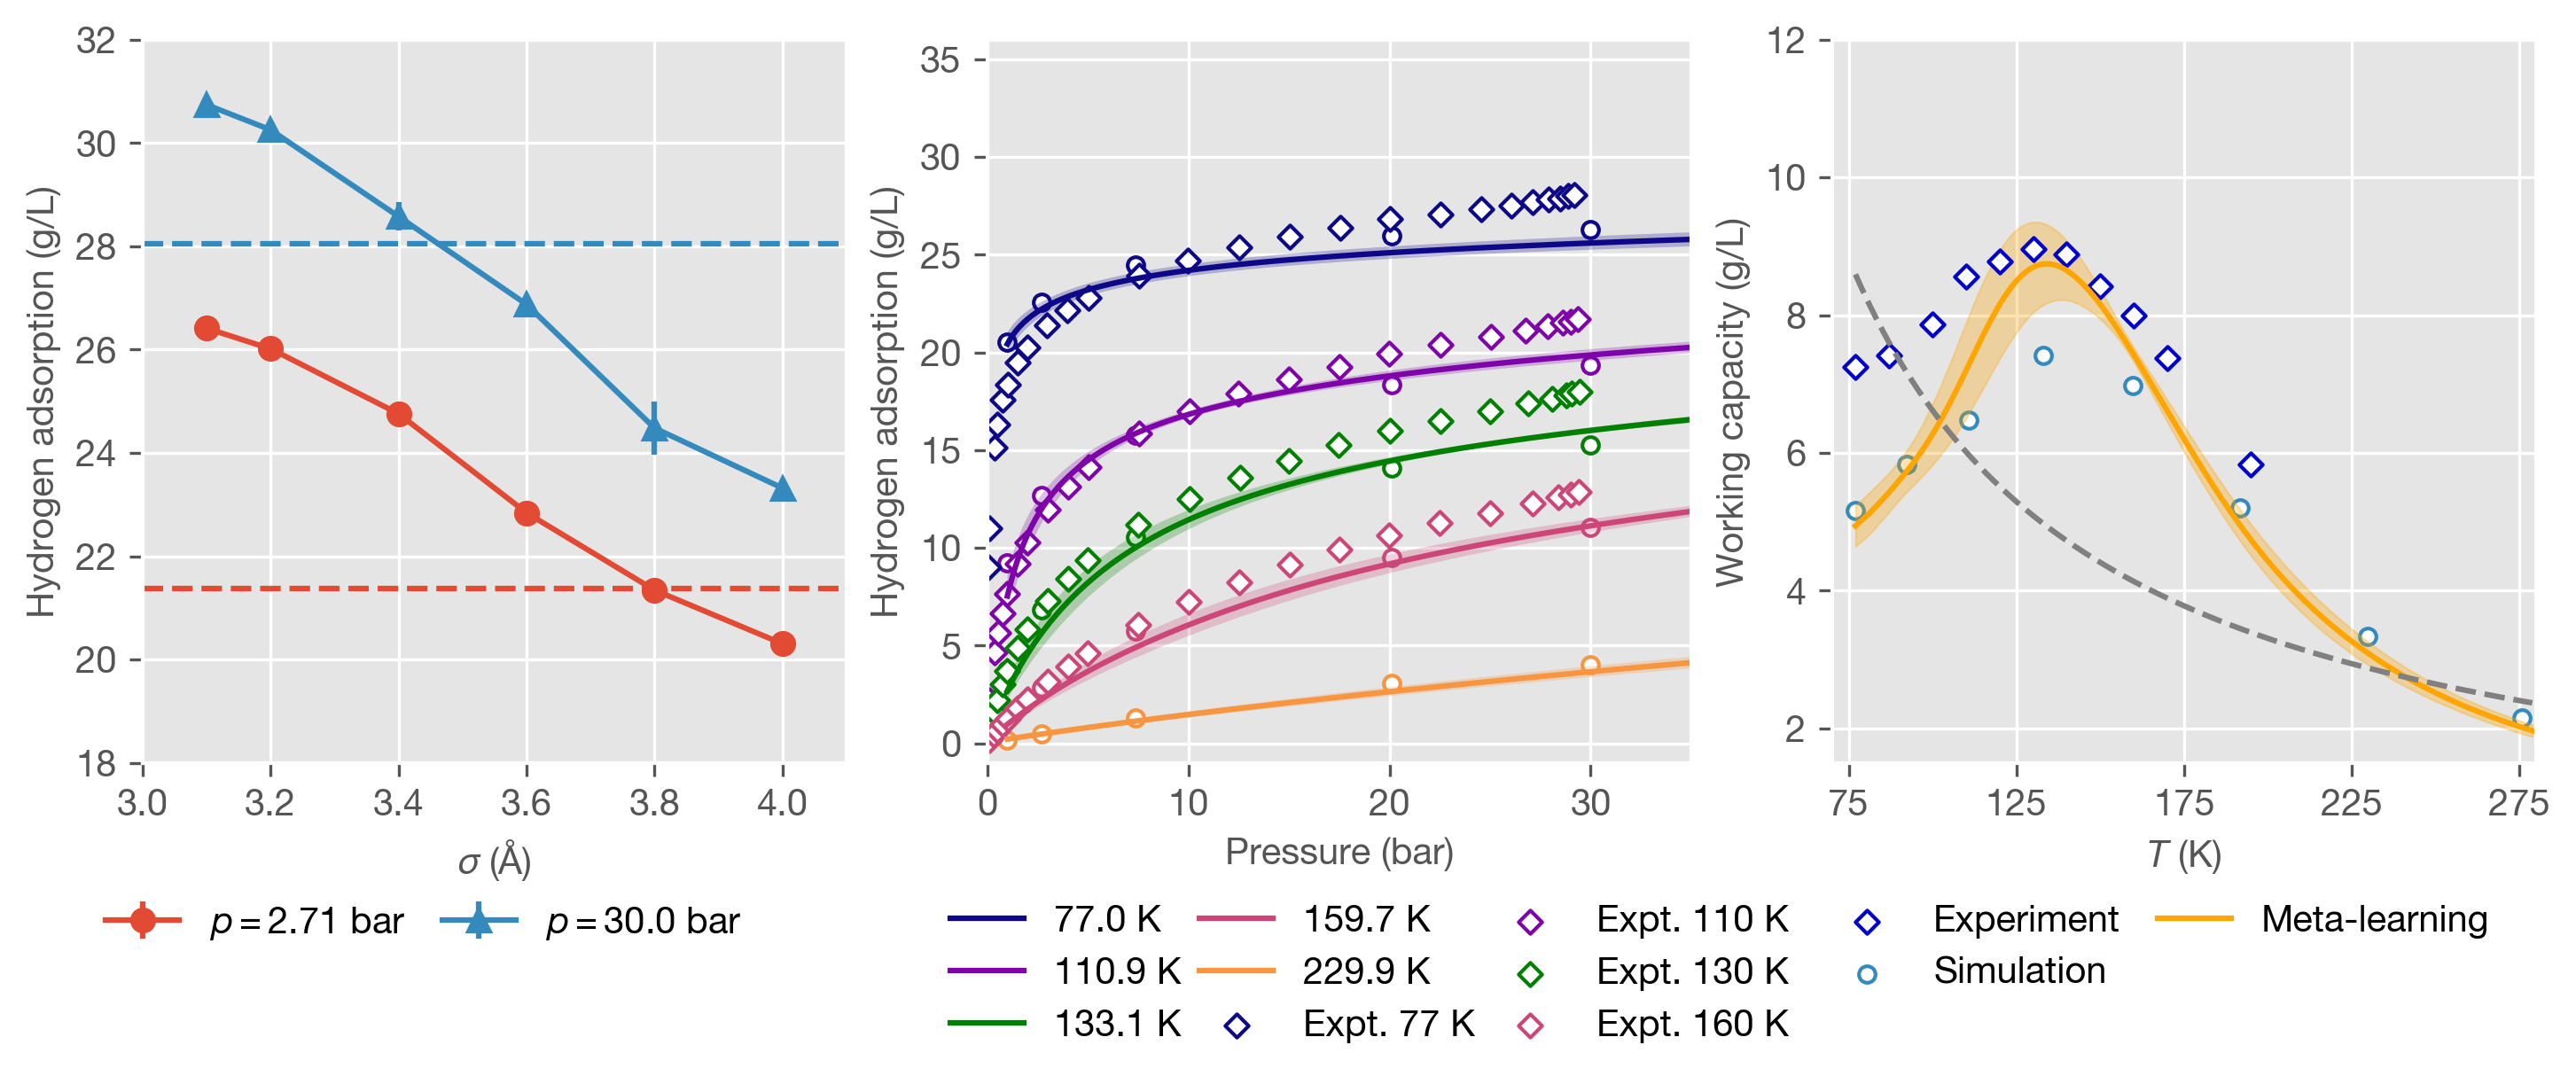

In [12]:
import matplotlib
c1 = np.array([52,138,189]) / 255

df_lta_ca = pd.read_csv("results/supplementary/LTA-Ca-finetune.csv", index_col=0).loc[:11]
exp_p1 = 28.05093888
exp_p0 = 21.36841834
data_p0 = df_lta_ca.loc[df_lta_ca["pressure"] == 2.71]
data_p1 = df_lta_ca.loc[df_lta_ca["pressure"] == 30]

eos = lambda p, T: p * 2.0158 / T / 0.08314
def get_capacity(df, key, p0, p1, e):
    R = 0.08314
    df = df.sort_values(by='temperature')
    temps = df.values[np.logical_and(df['zeolite'] == key, df['pressure'] == p0), 2]
    q0 = df.values[np.logical_and(df['zeolite'] == key, df['pressure'] == p0), -1]
    q1 = df.values[np.logical_and(df['zeolite'] == key, df['pressure'] == p1), -1]
    capacity = ((q1 - q0) * (1-e) + e * (p1 - p0) / R / temps) * 2.0158
    return temps, capacity

key = "LTA-Ca-3.6"
data = pd.read_csv('results/supplementary/LTA-isotherm-3.6.csv', index_col=0)
data["zeolite"] = key
temperatures = [77.0, 110.88, 133.06, 159.67, 229.92]
pressures = np.array([1.0, 2.71, 7.39, 20.09, 30.0, 54.60, 148.4, 403.4])

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(9,4)
fig.set_dpi(300)

lines = []
lines.append(axes[0].errorbar(data_p0["sigma"], np.mean(data_p0.iloc[:, 2:] * 2.0158, axis=1),
             yerr = np.std(data_p0.iloc[:, 2:] * 2.0158, axis=1), marker="o"))
data_p1 = df_lta_ca.loc[df_lta_ca["pressure"] == 30]
lines.append(axes[0].errorbar(data_p1["sigma"], np.mean(data_p1.iloc[:, 2:] * 2.0158, axis=1),
             yerr = np.std(data_p1.iloc[:, 2:] * 2.0158, axis=1), marker="^"))
axes[0].plot([3, 5], [exp_p0, exp_p0], color="C0", ls="--")
axes[0].plot([3, 5], [exp_p1, exp_p1], color="C1", ls="--")
axes[0].set_xlim([3.0, 4.1])
axes[0].set_ylim([18, 32])
axes[0].set_xlabel("$\sigma$ ($\mathrm{\AA}$)",fontsize=10)
axes[0].set_ylabel("Hydrogen adsorption (g/L)",fontsize=10)
axes[0].legend(lines, ["$p=2.71$ bar", "$p=30.0$ bar"],
              loc='upper left', bbox_to_anchor=(-0.1, -0.15), 
               columnspacing=1, ncol=3, frameon=False, fontsize=10)
cmap = matplotlib.cm.get_cmap('plasma', 9)
colors = cmap(range(12))[::2]
plt.subplots_adjust(wspace=0.2, hspace=0.25, left=0, right=1, bottom=0.2)
axes[1].set_ylabel('Hydrogen adsorption (g/L)',fontsize=10)
axes[2].set_ylabel('Working capacity (g/L)', fontsize=10)
lines_top = []
lines_bottom = []
colors_fig7 = colors[:2].tolist() + ["green"] + colors[2:4].tolist()


ax = axes[1]
data_pred = np.loadtxt('results/isotherms/%s.txt' % key)
for i, zipped in enumerate(zip(colors_fig7, temperatures)):
    c, temp = zipped
    loadings = data.loc[data['temperature'] == temp].sort_values('pressure')['loading'].values
    ax.scatter(pressures, loadings * 2.0158, 
            color='1', linewidth=1, edgecolors=c, s=20)
    y_pred = data_pred[:, 1 + 2*i] * 2.0158
    y_err = data_pred[:, 2 + 2*i] * 2.0158
    line = ax.plot(data_pred[:, 0], y_pred, color=c)[0]
    lines_top.append(line)
    ax.fill_between(data_pred[:, 0], y_pred - y_err, y_pred + y_err, color=c, alpha=0.25, lw=0)

ax.set_xlabel('Pressure (bar)',fontsize=10)
ax = axes[2]
temps, y_init = get_capacity(data, key, 2.71, 30, 0.3)

data_pred = np.loadtxt('results/capacity/%s_capacity.txt' % key)
n_h2 = eos(30, data_pred[:, 0]) - eos(2.71, data_pred[:, 0])
line1 = ax.scatter(temps, y_init, marker='o', 
                          color='1', linewidth=1, edgecolors=c1, s=20)
line3 = ax.plot(data_pred[:, 0], data_pred[:, 1], color='orange')[0]

ax.fill_between(data_pred[:, 0], data_pred[:, 1]+data_pred[:, 2],data_pred[:, 1]-data_pred[:, 2], color='orange', alpha=0.3)
ax.plot(data_pred[:, 0], n_h2, color="0.5", ls='--')
ax.set_xlabel('$T$ (K)', fontsize=10)
    
axes[1].set_ylim([-1, 36])
axes[1].set_xlim([0, 35])
axes[2].set_xticks([75, 125, 175, 225, 275])
axes[2].set_xlim([70, 280])
axes[2].set_ylim([1.5, 12])
    
isotherms_exp = np.load("experimental/LTA-Ca-isotherm-abs.npy", allow_pickle=True)
exp1 = axes[1].scatter(isotherms_exp[0][:, 0], isotherms_exp[0][:, 1], marker='D', 
                              color='1', linewidth=1, edgecolors=colors[0], s=20)
exp2 = axes[1].scatter(isotherms_exp[3][:, 0], isotherms_exp[3][:, 1], marker='D', 
                              color='1', linewidth=1, edgecolors=colors[1], s=20)
exp3 = axes[1].scatter(isotherms_exp[5][:, 0], isotherms_exp[5][:, 1], marker='D', 
                              color='1', linewidth=1, edgecolors='green', s=20)
exp4 = axes[1].scatter(isotherms_exp[8][:, 0], isotherms_exp[8][:, 1], marker='D', 
                              color='1', linewidth=1, edgecolors=colors[2], s=20)

t_isotherm = [77, 110, 130, 160]
ind_isotherm = [0, 3, 5, 8]


n_exp = np.loadtxt('experimental/LTA-Ca-optimal-temp.npy')
line4 = axes[2].scatter(n_exp[:, 0], n_exp[:, 1], marker='D', 
                        color='1', linewidth=1, edgecolors='mediumblue', s=20)

    
    
axes[1].legend(lines_top + [exp1, exp2, exp3, exp4], 
               ["%.1f K" % x for x in temperatures] + \
               ['Expt. 77 K', 'Expt. 110 K', 'Expt. 130 K', 'Expt. 160 K'],
               loc='upper left', bbox_to_anchor=(-0.1, -0.15), 
               columnspacing=0.5, ncol=3, frameon=False, fontsize=10)
axes[2].legend([line4, line1, line3], 
           ['Experiment', 'Simulation','Meta-learning'], 
            loc='upper left', bbox_to_anchor=(-0.05, -0.15), 
            columnspacing=1, ncol=2, frameon=False, fontsize=10)
#plt.savefig("figure-S12.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Figure S13

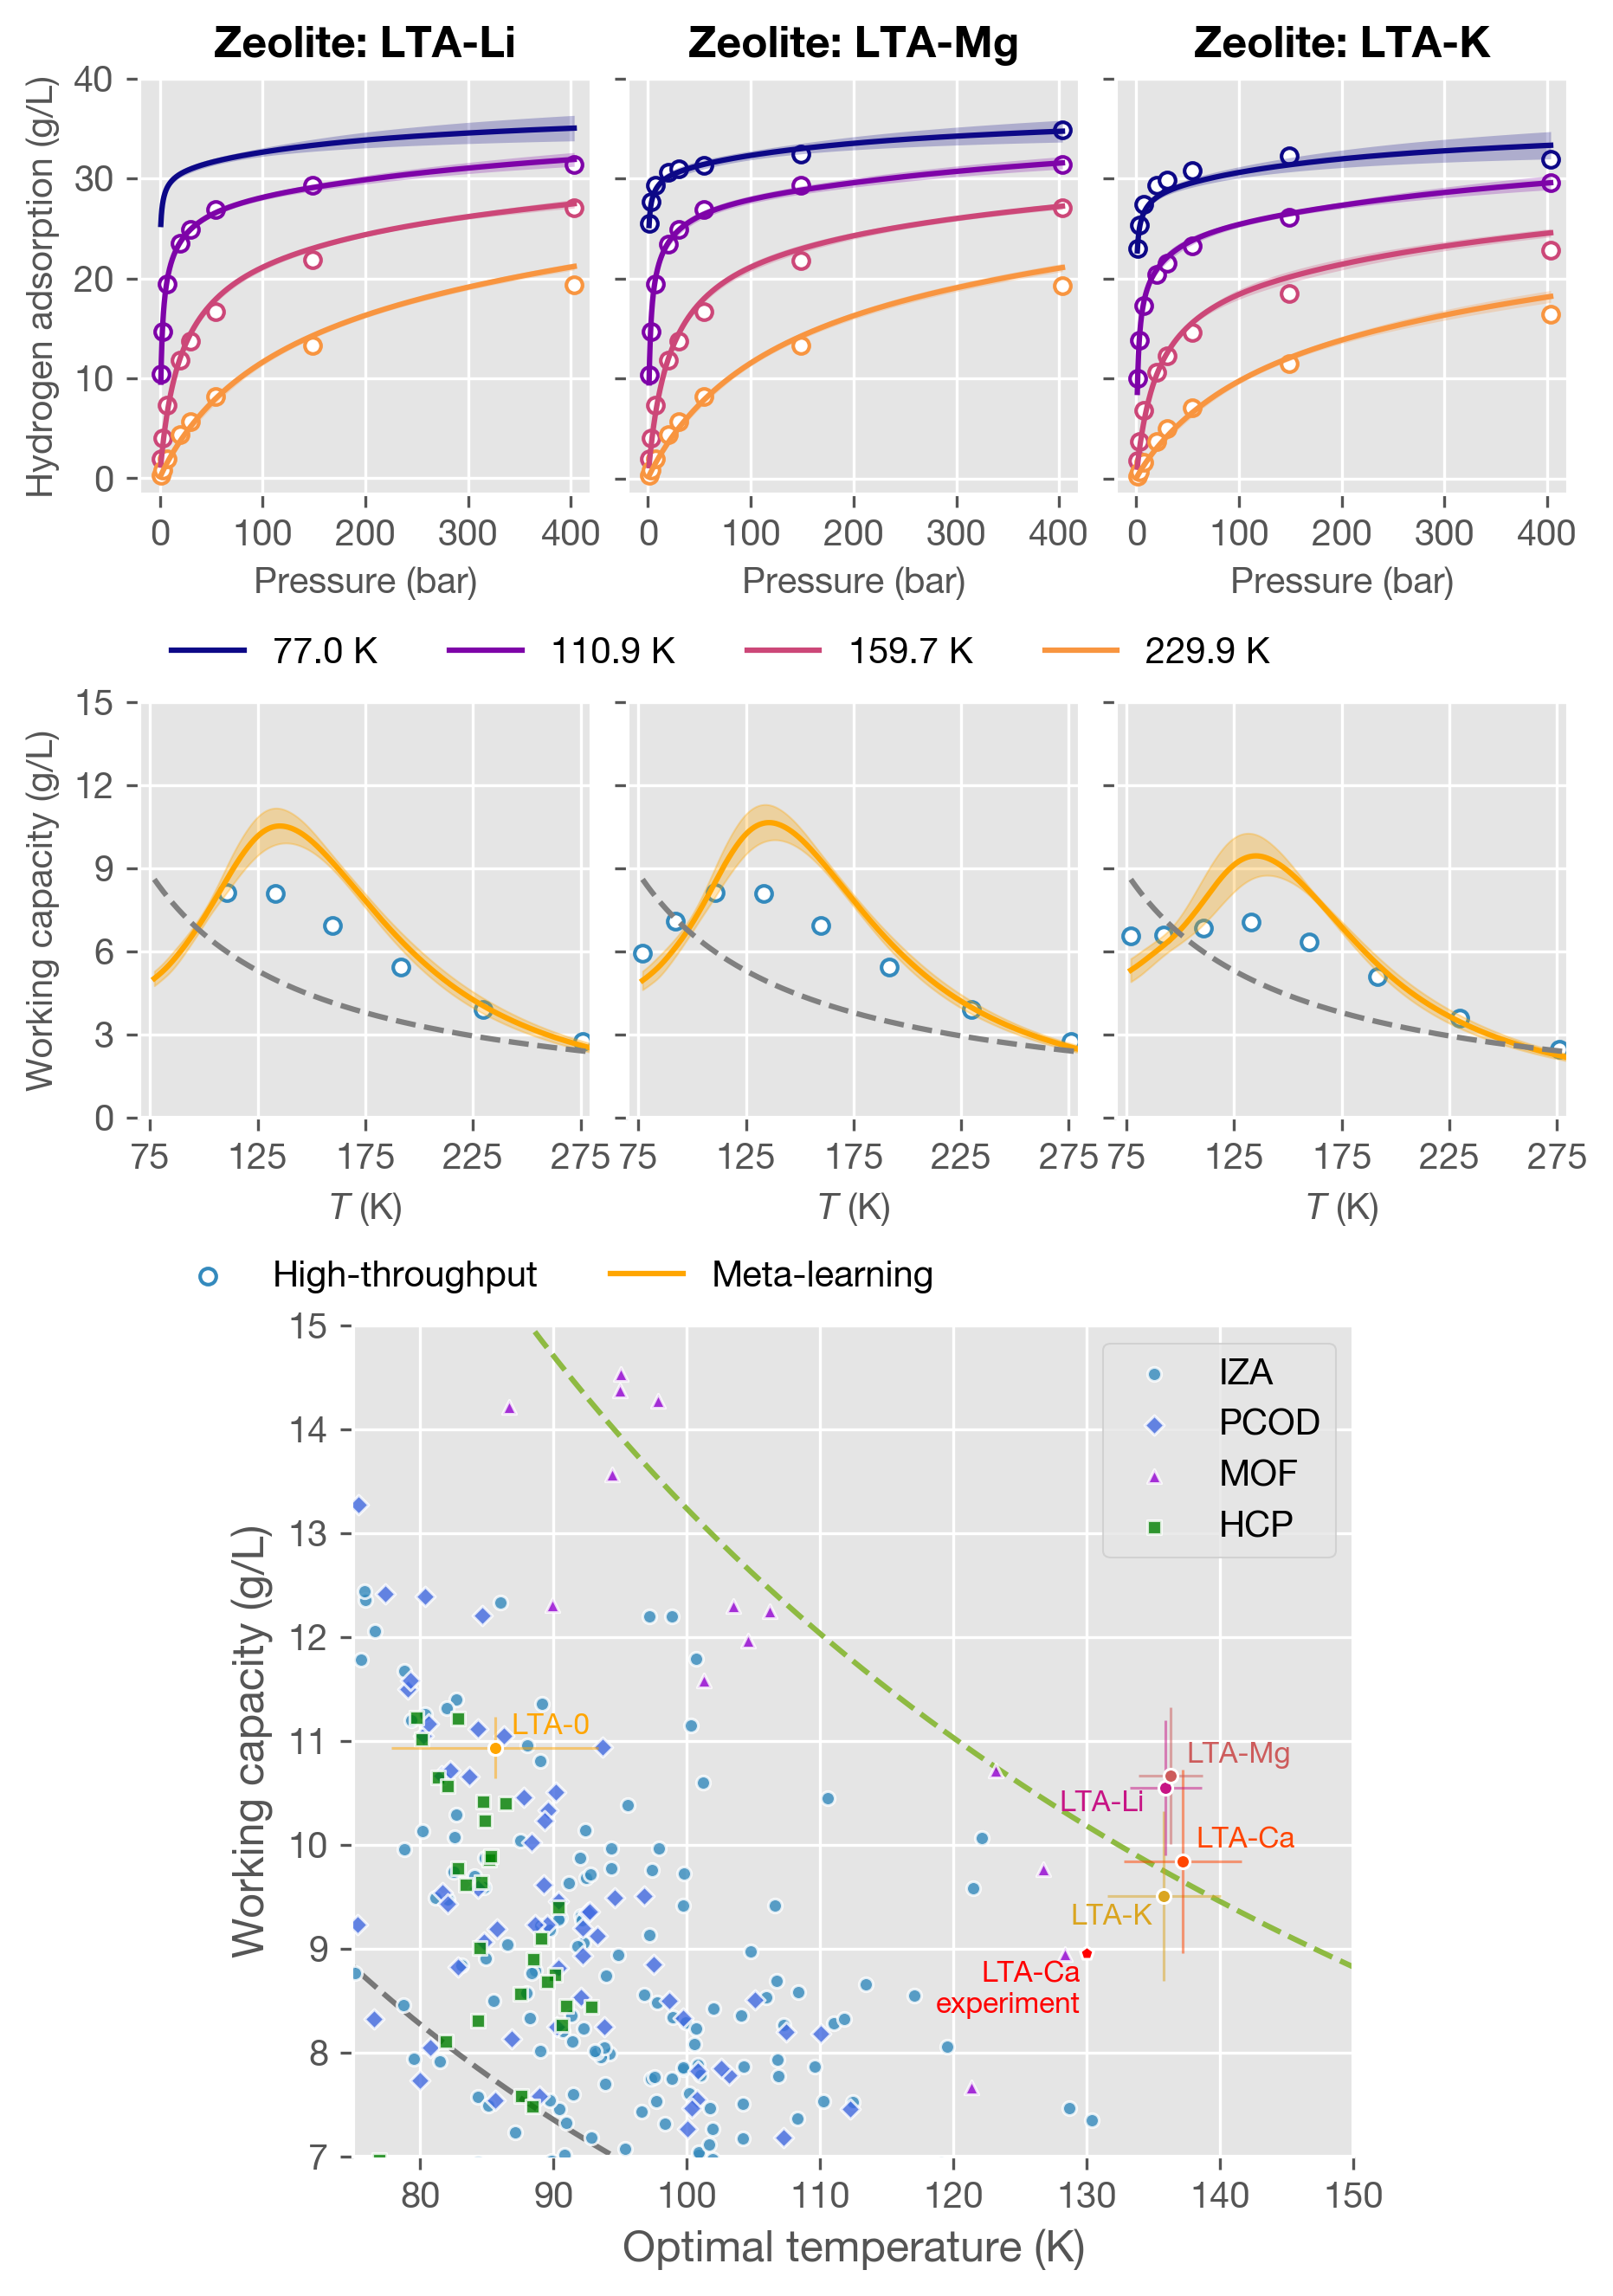

In [18]:
c1 = np.array([52,138,189]) / 255
# Figure 4
def get_capacity_np(data, key, p0, p1, e):
    R = 0.08314
    if '-' not in key:
        key += '-0'
    loadings = data[keys == key, :][0]
    q0 = loadings[:, loadings[1, :] == np.log(p0)][0, :]
    q1 = loadings[:, loadings[1, :] == np.log(p1)][0, :]
    temps = 1000 / loadings[:, loadings[1, :] == np.log(p0)][2, :]
    capacity = ((q1 - q0) * (1-e) + e * (p1 - p0) / R / temps) * 2.0158
    return temps, capacity, None

eos = lambda p, T: p * 2.0158 / T / 0.08314

keys = np.genfromtxt('../data/cation-exchange/names.csv', dtype=str)
data = np.load('../data/cation-exchange/LTA-sim.npy')
norms = np.loadtxt('../data/cation-exchange/norms.csv')

data[:, 0, :] *= norms.reshape(-1, 1)
#  LTA-Li-FF-5 uses 48 points to generate prediction
data[keys == "LTA-Li-FF-5", :, :] = np.nan
data[keys == "LTA-Li-FF-5", :, :48] = np.load("../data/cation-exchange/Li-FF-5/data.npy")
data[keys == "LTA-Li-FF-5", 0, :] *= np.loadtxt('../data/cation-exchange/Li-FF-5/norms.csv')

temperatures = [77.0, 110.88, 159.67, 229.92]
pressures = np.array([1.0, 2.71, 7.39, 20.09, 30.0, 54.60, 148.4, 403.4])

cmap = matplotlib.cm.get_cmap('plasma', 9)
colors = cmap(range(12))[::2]
color_dict = {'RWY': c1, 'MTN': 'C5'}
opt_temps = {'RWY': 64.2, 'SBN': 120, 'MON': 100, 'MTN': 145, 'MEP': 145,
            'IRY': 64.2, 'JST': 100, 'DOH': 150}

zeolites_plot = ['LTA-Li-FF-5', 'LTA-Mg-FF-5', 'LTA-K-FF-5']
fig, axes = plt.subplots(2, len(zeolites_plot))
plt.tight_layout()
fig.set_size_inches(5.5, 8)
fig.set_dpi(300)

plt.subplots_adjust(wspace=0.08, hspace=0.5, left=0, right=1, top=1, bottom=0.5)
axes[0, 0].set_ylabel('Hydrogen adsorption (g/L)',fontsize=10)
axes[1, 0].set_ylabel('Working capacity (g/L)', fontsize=10)
lines_top = []
lines_bottom = []
for j, key in enumerate(zeolites_plot):
    ax = axes[0, j]
    ax.set_title("Zeolite: %s" % key[:-5], fontsize=12, fontweight="bold")
    data_pred = np.loadtxt('results/isotherms/%s.txt' % key)
    for i, zipped in enumerate(zip(colors[:4], temperatures)):
        c, temp = zipped
        loadings = data[keys == key, :][0]
        pres_plot = np.exp(loadings[:, loadings[2, :] == 1000 / temp][1, :])
        loadings = loadings[:, loadings[2, :] == 1000 / temp][0, :]
        ax.scatter(pres_plot, loadings * 2.0158, 
                color='1', linewidth=1, edgecolors=c, s=20)
        y_pred = data_pred[:, 1 + 2*i] * 2.0158
        y_err = data_pred[:, 2 + 2*i] * 2.0158
        line = ax.plot(data_pred[:, 0], y_pred, color=c)[0]
        if j == 0:
            lines_top.append(line)
        ax.fill_between(data_pred[:, 0], y_pred - y_err, y_pred + y_err, color=c, alpha=0.25, lw=0)
    

    ax.set_xlabel('Pressure (bar)',fontsize=10)
    ax.set_xlim([-20, 420])
    ax = axes[1, j]
    temps, y_init, y_init_err = get_capacity_np(data, key, 2.71, 30, 0.5)
    data_pred = np.loadtxt('results/capacity/%s_capacity.txt' % key)
    n_h2 = eos(30, data_pred[:, 0]) - eos(2.71, data_pred[:, 0])
    line1 = ax.scatter(temps, y_init, marker='o', 
                              color='1', linewidth=1, edgecolors=c1, s=20)

    line3 = ax.plot(data_pred[:, 0], data_pred[:, 1], color='orange')[0]
    
    ax.fill_between(data_pred[:, 0], data_pred[:, 1]+data_pred[:, 2],data_pred[:, 1]-data_pred[:, 2], color='orange', alpha=0.3)
    ax.plot(data_pred[:, 0], n_h2, color="0.5", ls='--')
    ax.set_xlabel('$T$ (K)', fontsize=10)
    
for ax in axes[:, 1:].ravel():
    ax.set_yticklabels([])     
for a in axes[0, :]:
    a.set_xticks([0, 100, 200, 300, 400])
    a.set_yticks([0, 10, 20, 30, 40])
for a in axes[1, :]:
    a.set_xticks([75, 125, 175, 225, 275])
    a.set_yticks([0, 3, 6, 9, 12, 15])
    a.set_xlim([70, 280])
    
ax_main = fig.add_axes((0.15, 0, 0.7, 0.4))
    
fig.legend(lines_top, ["%.1f K" %x for x in temperatures] + ['$T_{\mathrm{val,max}}$'], 
           loc='lower left', bbox_to_anchor=(0.0, 0.70), ncol=4, frameon=False)
fig.legend([line1, line3], 
           ['High-throughput', 'Meta-learning'], frameon=False, 
           loc='lower left', bbox_to_anchor=(0.0, 0.40), ncol=5)


c1 = np.array([52,138,189]) / 255

rgb = lambda x: np.array(matplotlib.colors.to_rgb(x))
df_cation = pd.read_csv("results/cation-exchange/temps-p02.71-p30-f0.7-swing0.csv", index_col=0, dtype={'Zeolite': str})
df_iza = pd.read_csv("results/iza/temps-p02.71-p30-f0.7-swing0.csv", index_col=0, dtype={'Zeolite': str})
df_pcod = pd.read_csv("results/pcod/temps-p02.71-p30-f0.7-swing0.csv", index_col=0, dtype={'Zeolite': str})
df_mof = pd.read_csv("results/mof/temps-p02.71-p30-f0.7-swing0.csv", index_col=0, dtype={'Zeolite': str})
df_hcp = pd.read_csv("results/hcp/temps-p02.71-p30-f0.7-swing0.csv", index_col=0, dtype={'Zeolite': str})

R = 0.08314
eos = lambda p, V, T: p * V / R / T
p1 = 30
p0 = 2.71

ylim = [7, 15]
xlim = [75, 150]

colors = [c1, 
          rgb('royalblue'), 
          rgb('darkviolet'),
          rgb('green'),
          rgb('C4')
         ]

markers = ['o', 'D', '^', 's', 'h']
size = 15
lw = 0.75
alpha = 0.8

lines = []
xoffsets = [1.2, 1.0, -7, 1.2, -8]
yoffsets = [0.2, 0.2, -0.2, 0.2, -0.15]
val_colors = ['orange', 'orangered', 'goldenrod', 'indianred', 'mediumvioletred']

for i, df in enumerate([df_iza, df_pcod, df_mof, df_hcp, df_cation]):
    x = df['Optimal temperature (K)'].values
    y = df['Tank capacity (mol)'].values
    x_err = df['Optimal temperature error (K)'].values
    y_err = df['Tank capacity error (mol)'].values
    name = df['Zeolite'].values
    if i != 4:
        lines.append(ax_main.scatter(x, y, color=colors[i], marker=markers[i], 
                                     edgecolor="1", zorder=10, s=size, linewidth=lw, alpha=alpha))
    validated = ['LTA-0', 'LTA-Ca-FF-5', 'LTA-K-FF-5', 'LTA-Mg-FF-5', 'LTA-Li-FF-5']
    texts = ['LTA-0', 'LTA-Ca', 'LTA-K', 'LTA-Mg', 'LTA-Li']
    
    for i in range(len(name)):
        y_gas = (eos(p1, 2.0158, x[i]) - eos(p0, 2.0158, x[i]))
        if name[i] in validated:
            j = validated.index(name[i])
            ax_main.text(x[i]+xoffsets[j], y[i]+yoffsets[j], texts[j], 
                         fontsize=8, color=val_colors[j], rotation=0,
                         horizontalalignment='left',
                         verticalalignment='center', zorder=100)
            ax_main.scatter(x[i], y[i], color=val_colors[j], edgecolor="1", s=size, linewidth=lw, zorder=100)
            ax_main.errorbar(x[i], y[i], xerr=x_err[i], yerr=y_err[i], color=val_colors[j], marker='', 
                             ls='', linewidth=0.75, alpha=0.5, zorder=50)

ax_main.scatter(130, 8.958926, color='red', edgecolor="1", s=size, linewidth=lw, zorder=120, marker='p')
ax_main.text(129.5, 8.6, "LTA-Ca\nexperiment",
              fontsize=8, color='red', rotation=0,
              horizontalalignment='right',
              verticalalignment='center', zorder=100)

x_line = np.linspace(30,150,200)
y_line = (eos(p1, 2.0158, x_line) - eos(p0, 2.0158, x_line))
ax_main.plot(x_line, y_line, color='C3', ls='--')
ax_main.plot(x_line, 2*y_line, color='C5', ls='--')
ax_main.set_xlim(xlim)
ax_main.set_ylim(ylim)
ax_main.set_xlabel('Optimal temperature (K)')
ax_main.set_ylabel('Working capacity (g/L)')
ax_main.legend(lines, ['IZA', 'PCOD', 'MOF', 'HCP', "LTA(SiAl)"], loc='best')
#plt.savefig("figure-S13.pdf", format='pdf', bbox_inches="tight")
plt.show()


## Figure S14
The validation loss is lower than training loss is because the training loss contains correlation penalty.

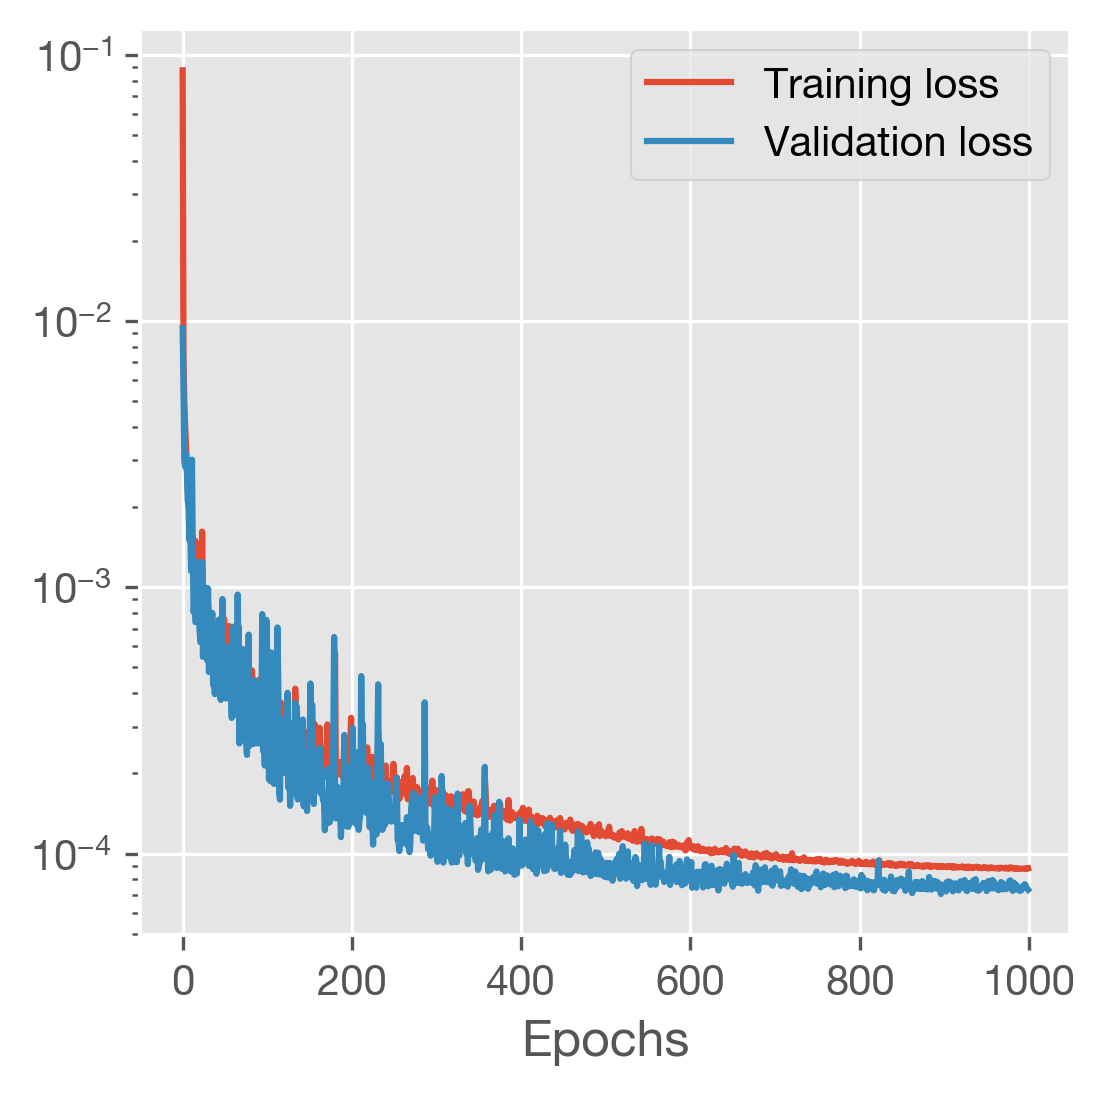

In [20]:
import os
training_curves = []
for f in os.listdir("model-ensemble/"):
    if '-0-loss.txt' in f:
        training_curves.append(np.loadtxt("model-ensemble/" + f))
plt.figure(figsize=(4,4), dpi=300)
for t in training_curves:
    plt.plot(t[:, 0])
    plt.plot(t[:, 1])
plt.yscale('log')
plt.xlabel("Epochs")
plt.legend(["Training loss", "Validation loss"])
#plt.savefig("figure-S14.pdf", format='pdf', bbox_inches="tight")
plt.show()

## Figure S15

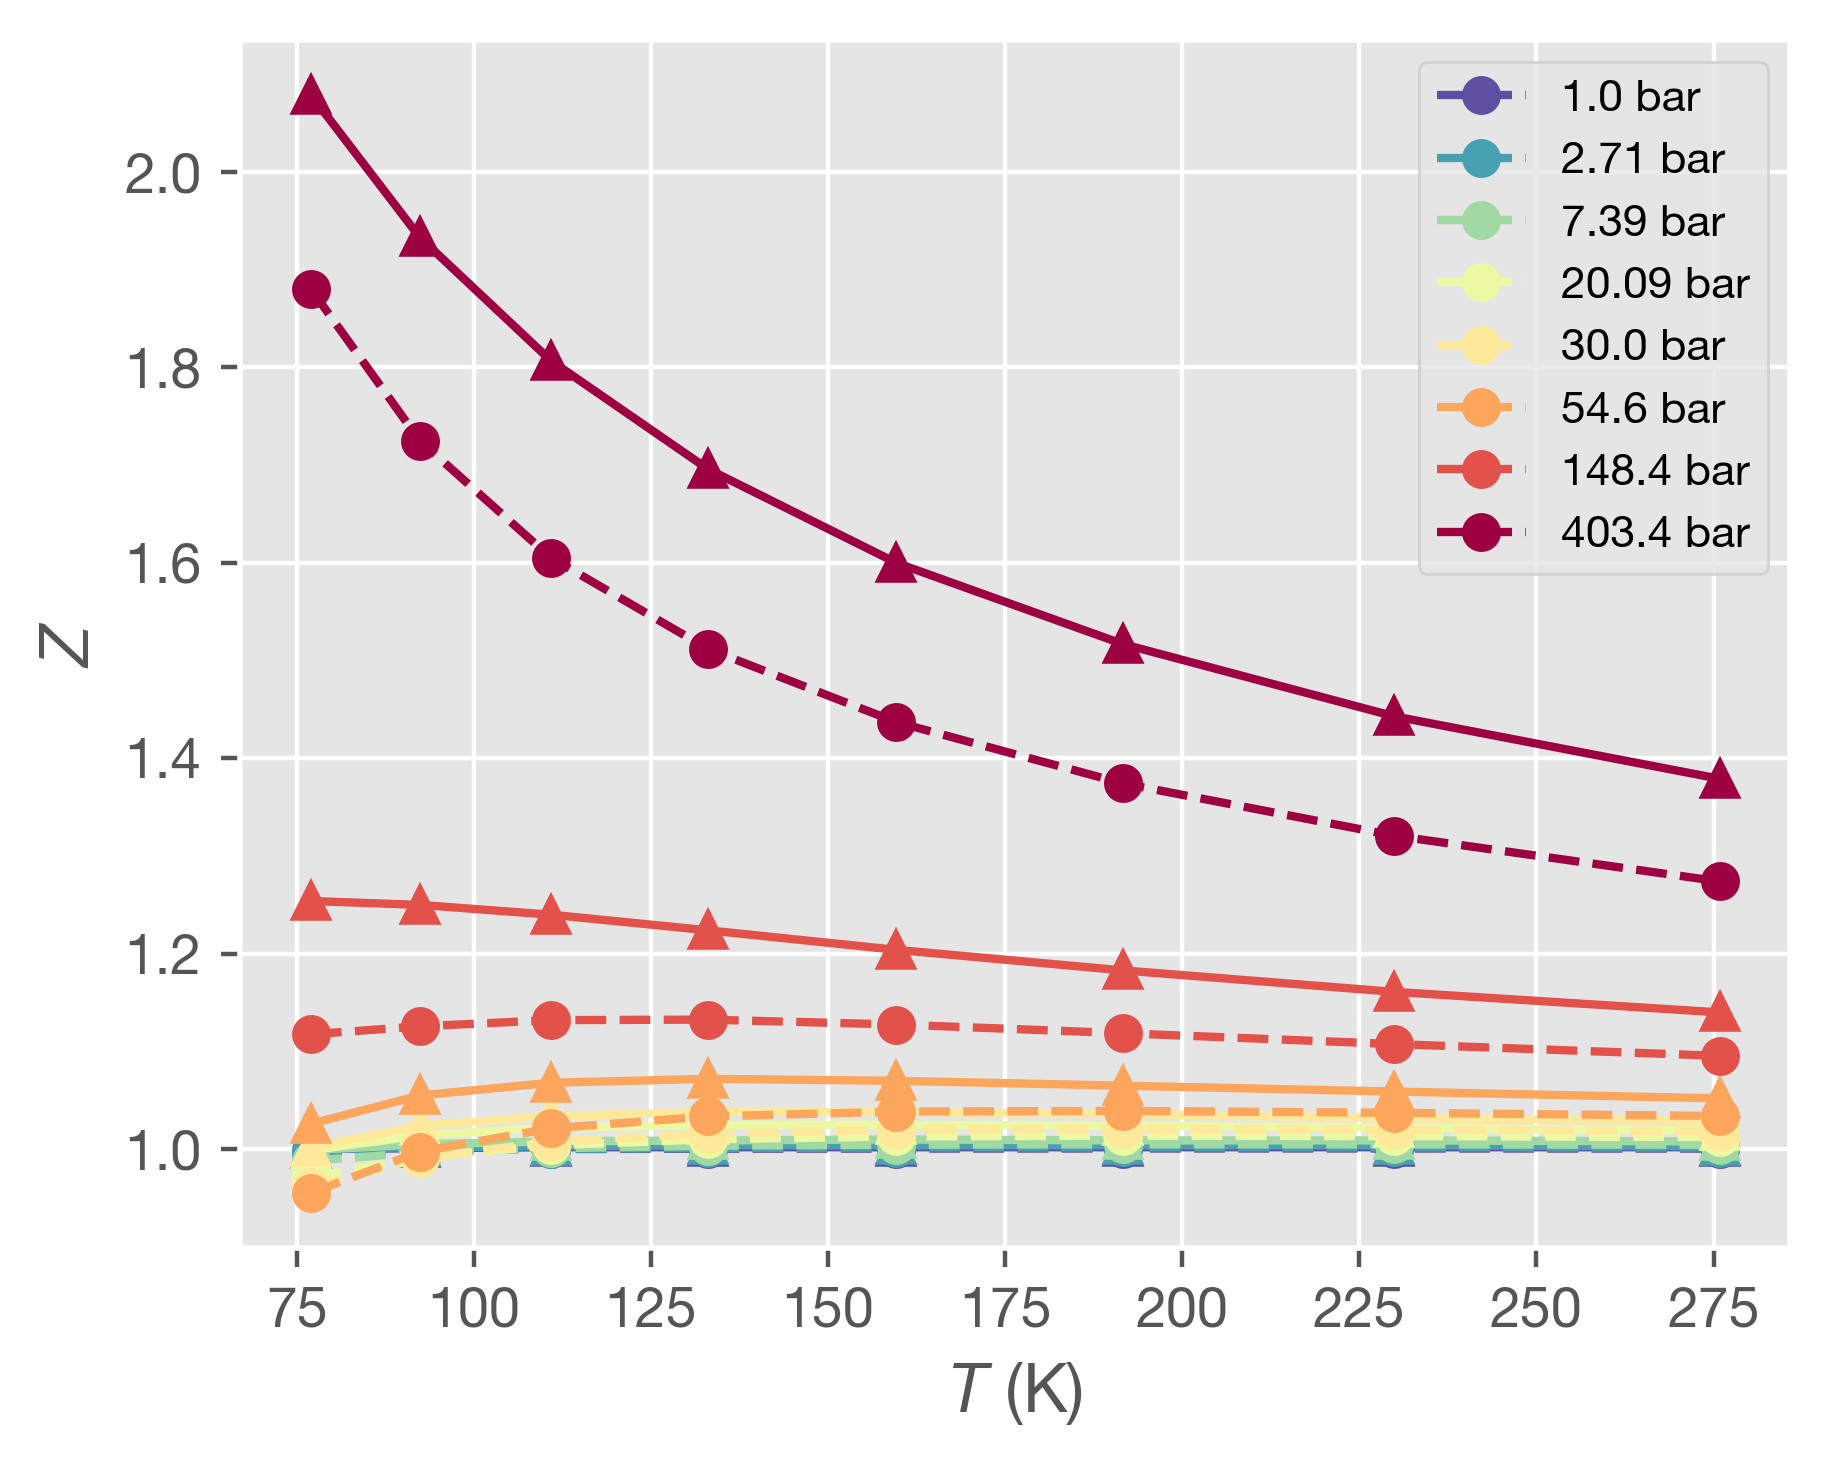

In [21]:
import pandas as pd
df_eos = pd.read_csv("results/supplementary/GEMC-Leachman-eos.csv")
pressures = df_eos['p'].unique()
plt.figure(figsize=(5, 4), dpi=400)
cmap = matplotlib.cm.get_cmap('Spectral', 8)
colors = cmap(range(8))[::-1]
lines = []
for i in range(len(pressures)):
    df_slice = df_eos.loc[df_eos["p"] == pressures[i]]
    lines.append(plt.plot(df_slice["T"], df_slice["Znist"], color=colors[i], ls='--', marker='o')[0])
    plt.plot(df_slice["T"], df_slice["Zsim"], color=colors[i], ls='-', marker='^')
plt.legend(lines, [f"{x} bar" for x in pressures], fontsize=8)
plt.xlabel("$T$ (K)")
plt.ylabel("$Z$")
#plt.savefig("figure-S15.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Figure S16

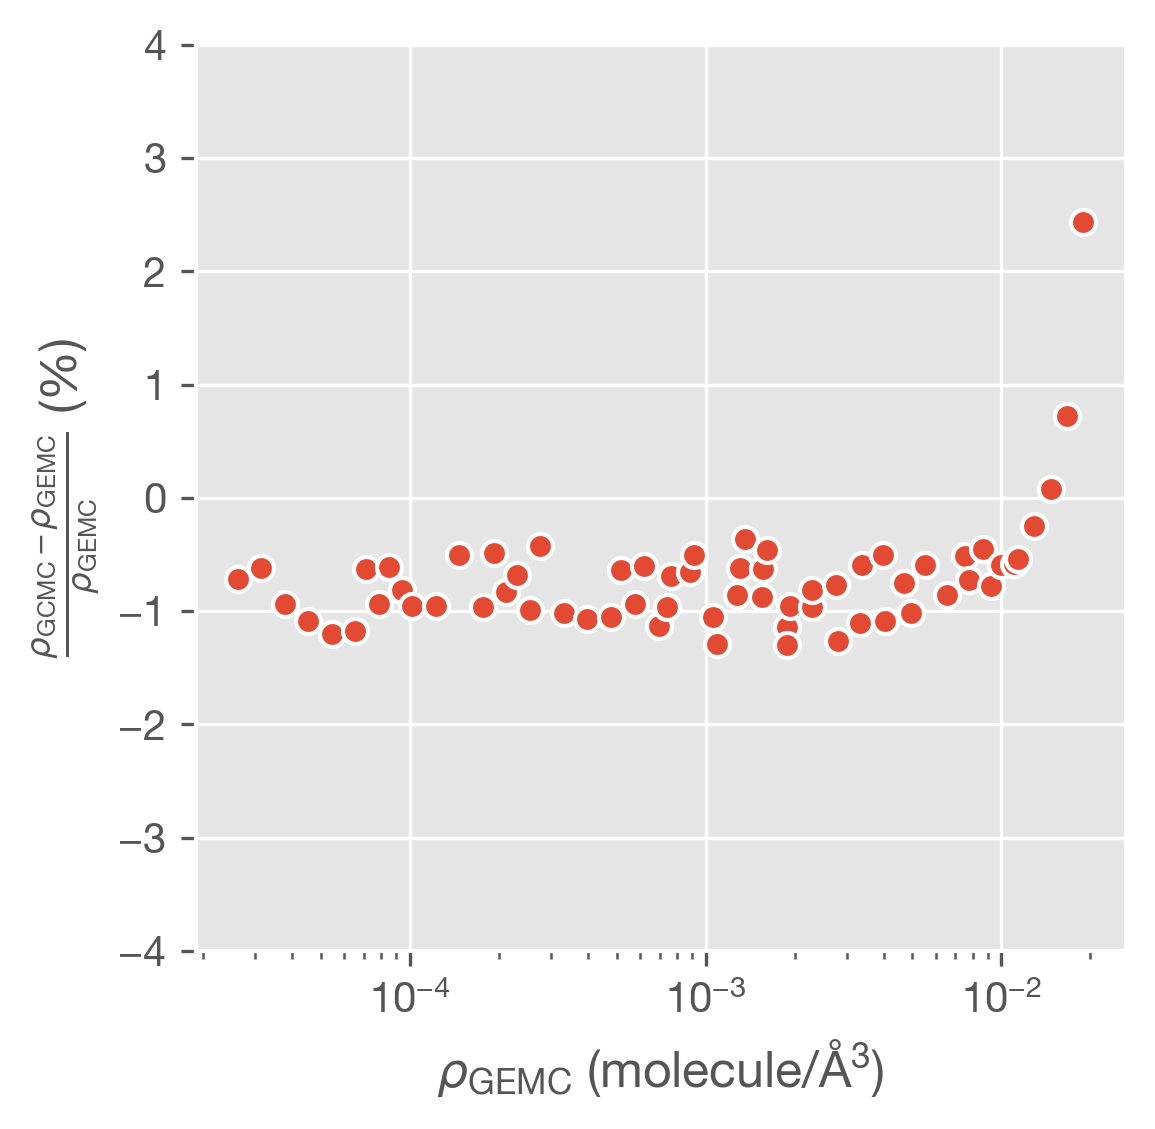

In [22]:
densities = pd.read_csv("results/supplementary/number_densities.csv")
plt.figure(figsize=(4,4), dpi=300)
rho_gemc = densities["GEMC density mean (molecule/angstrom^3)"]
rho_gcmc = densities["GCMC density (molecule/angstrom^3)"]
ind = np.argsort(rho_gemc)
rho_gemc = rho_gemc[ind]
rho_gcmc = rho_gcmc[ind]
std_gemc = densities["GEMC density standard deviation (molecule/angstrom^3)"][ind]
plt.scatter(rho_gemc, 100 * (rho_gcmc - rho_gemc) / rho_gemc, linewidth=1, edgecolor="1")
plt.ylim([-4, 4])
plt.xscale('log')
plt.xlabel("$\\rho_\mathrm{GEMC}$ (molecule/$\mathrm{\AA}^3$)")
plt.ylabel("$\\frac{\\rho_\mathrm{GCMC}-\\rho_\mathrm{GEMC}}{\\rho_\mathrm{GEMC}}$ (%)")
#plt.savefig("figure-S16.pdf", format='pdf', bbox_inches="tight")
plt.show()